# Aprendizaje Automático - Práctica 2 - Complejidad de H y Modelos Lineales

#### Valoración máxima: 12 puntos (+1.5 puntos de Bonus)

#### Fecha límite de entrega: 7 de Mayo de 2023 a las 23:59

#### Entrega a través de https://pradogrado2223.ugr.es/

### Nombre completo: <mark>JAVIER MORENO MORÓN</mark>



---

Este trabajo, cuya puntuación máxima será de 12 puntos (+1.5 puntos de bonus), pretende servir como práctica y refuerzo de los conocimientos adquiridos en teoría, relativos a modelos lineales de clasificación.

Límite de entrega: **7 de Mayo de 2023 a las 23:59 (PRADO)**


**Normas de desarrollo y entrega de trabajos**

- Única y exclusivamente se debe entregar este Notebook de Colab (fichero .ipynb). No es necesario entregar ninguna memoria externa, pero el código debe estar bien comentado, y todas las decisiones tomadas y el trabajo desarrollado deben documentarse suficientemente en celdas de texto. 

- La entrega en PRADO está configurada para permitir sucesivas entregas de la práctica. Desde este punto de vista, se recomienda subir versiones de la práctica a medida que se van realizando los distintos ejercicios propuestos, y no dejarlo todo para el final, dado que es altamente improbable que se extienda la fecha de entrega.  

- Reiterar que es obligatorio documentar las valoraciones y decisiones adoptadas en el desarrollo de cada uno de los apartados. Debe incluirse también una valoración razonada sobre la calidad de los
resultados obtenidos. Sin esta documentación, se considera que el trabajo NO ha sido presentado. 

- Se debe respetar la estructura y secciones del Notebook. Esto servirá para agilizar las correcciones, así como para identificar con facilidad qué ejercicio/apartado se está respondiendo. 

- El codigo NO puede escribir nada a disco.

- El path de lectura desde Google Drive debe ser siempre el mismo, que es el que se indica en este Notebook. 

- Una entrega es apta para ser corregida si se puede ejecutar de principio a fin sin errores.

- No es válido usar opciones en las entradas (es decir, utilizar el comando `input`, por ejemplo, para que el usuario escoja el valor de las variables para ejecutar el programa). Para ello, se deben fijar al comienzo los valores
por defecto que se consideren óptimos o que se soliciten en el enunciado.

- El código debe estar obligatoriamente comentado explicando lo que realizan los distintos apartados y/o bloques.

- Se entrega solamente este Notebook, y no los datos empleados.


---

## <font color='blue'>Ejercicio 1: COMPLEJIDAD DE H Y EL RUIDO (4 puntos)</font>

<font color='blue'>En este ejercicio intentaremos profundizar un poco en la dificultad que introduce el ruido de las etiquetas en la elección de la clase de funciones más adecuada para resolver un determinado problema. 



In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

# Fijamos la semilla aleatoria
np.random.seed(1)

<font color='blue'>Haremos uso de tres funciones, que se incluyen a continuación: 

<font color='blue'>$simula\_unif(N, dim, rango)$, que calcula una lista de $N$ vectores de dimensión $dim$. Cada vector contiene $dim$ números aleatorios uniformes en el intervalo $rango$.

In [2]:
def simula_unif(N, dim, rango):
	return np.random.uniform(rango[0],rango[1],(N,dim))

<font color='blue'>$simula\_gauss(N, dim, sigma)$, que calcula una lista de longitud $N$ de vectores de dimensión $dim$, donde cada posición del vector contiene un número aleatorio extraído de una distribucción Gaussiana de media 0 y varianza dada (para cada dimension, por la posición del vector $sigma$).

In [3]:
def simula_gauss(N, dim, sigma):
    media = 0    
    out = np.zeros((N,dim),np.float64)        
    for i in range(N):
        # Para cada columna dim se emplea un sigma determinado. Es decir, para 
        # la primera columna (eje X) se usará una N(0,sqrt(sigma[0])) 
        # y para la segunda (eje Y) N(0,sqrt(sigma[1]))
        out[i,:] = np.random.normal(loc=media, scale=np.sqrt(sigma), size=dim)
    
    return out

<font color='blue'>$simula\_recta(intervalo)$, que simula de forma aleatoria los parámetros $v = (a, b)$ de una
recta, $y = ax + b$, dado un determinado intervalo (dentro del cual se generan dos puntos aleatorios, que se emplearán para calcular la pendiente y el término independiente de la recta).

In [4]:
def simula_recta(intervalo):
    points = np.random.uniform(intervalo[0], intervalo[1], size=(2, 2))
    x1 = points[0,0]
    x2 = points[1,0]
    y1 = points[0,1]
    y2 = points[1,1]
    # y = a*x + b
    a = (y2-y1)/(x2-x1) # Cálculo de la pendiente.
    b = y1 - a*x1       # Cálculo del termino independiente.
    
    return a, b

#### <font color='blue'>a)  (1 punto) Visualización de puntos iniciales.

<font color='blue'>Vamos a valorar la influencia del ruido en la selección de la clase de funciones y su complejidad. Con ayuda de la función $simula\_unif()$ generamos una
muestra de 100 puntos 2D, en el intervalo $[-50, 50]$,  a los que vamos añadir una etiqueta usando el signo de la función $f(x, y) = y - ax - b$, es decir el signo de la distancia de cada punto a la recta simulada con
$simula\_recta()$.

Dibujar un gráfico 2D con los puntos etiquetados. Dibuje también la recta usada para etiquetar. Observe y verifique (por medio del error de clasificación) que todos los puntos están bien clasificados respecto de la recta.
</font>


In [5]:
"""
np.sign(0) da 0 (véase https://numpy.org/doc/stable/reference/generated/numpy.sign.html), lo que, en ciertas ocasiones, puede ser problemático
Por ese motivo, proporcionamos esta sencilla función que devuelve el signo del valor que se le proporciona como entrada
Si esta función se emplea con un array, se obtendrá el error "ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()"
Si quiere poder emplearse con arrays, bastaría vectorizarla:
		numeros = np.random.randint(-10,10,10)
		sgn = np.vectorize(signo)
		print(numeros)
		print(sgn(numeros))
"""
def signo(x):
	if x >= 0:
		return 1
	return -1

def f(x, y, a, b):
	return signo(y - a*x - b)

In [6]:
# Error de clasificación para la recta de la función f(x,y,a,b)
# x = puntos/vector de características
# y = tags
# a, b = pendiente y valor independiente de la recta
def clasifError(x,y,a,b):
  fallos = 0
  tam_y = int(y.shape[0])

  for i in range(tam_y):
    if y[i] == -1 and f(x[i, 0], x[i, 1], a, b) == 1: 
      fallos = fallos+1
    elif y[i] == 1 and f(x[i, 0], x[i, 1], a, b) == -1:
      fallos = fallos+1

  return fallos, (fallos/tam_y)*100

Misclassification rate:  0.0 %



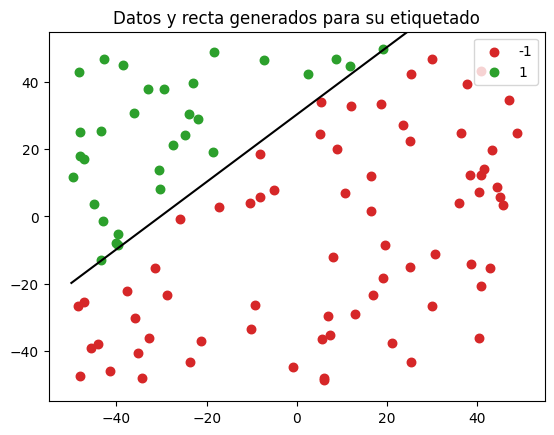

In [7]:
intervalo = [-50,50]

#Construimos la función etiquetadora
a, b = simula_recta(intervalo)

#Genero los puntos
puntos = simula_unif(100, 2, intervalo)

tags = np.zeros(100)

for i in range(100):
  tags[i] = f(puntos[i, 0], puntos[i, 1], a, b)

eClasi, porcError = clasifError(puntos, tags, a, b)

#Imprimo error
print('Misclassification rate: ', porcError, '%\n')

# Creo unas figura 
fig, ax = plt.subplots()

# Separamos los datos según su clase
puntos_tags = np.hstack((puntos, tags.reshape(-1, 1)))

bajo_f = puntos_tags[puntos_tags[:, -1] == -1]
sobre_f = puntos_tags[puntos_tags[:, -1] == 1]

# Visualizamos los datos con un Scatter plot
bajo_f_x = bajo_f[:, 0]
bajo_f_y = bajo_f[:, 1]
sobre_f_x = sobre_f[:, 0]
sobre_f_y = sobre_f[:, 1]

# Dibujamos los datos
ax.scatter(bajo_f_x, bajo_f_y, color='tab:red', marker = '.', s = 150)
ax.scatter(sobre_f_x, sobre_f_y, color='tab:green', marker = '.', s = 150)

# Dibujamos la recta de etiquetado
X = np.linspace(-50, 50, 100)
Y = a*X + b

ax.plot(X, Y, color=(.0, .0, .0))

# Acotamos las coordenadas de la gráfica
ax.set(xlim=(-55, 55), ylim=(-55, 55))

# Añadimos los títulos
ax.set_title('Datos y recta generados para su etiquetado')

# Añadimos la leyenda
ax.legend(('-1', '1'), loc='upper right')

plt.show()

Visualizamos tanto la nube de puntos generada, como su función clasificadora, al calcular el error de clasificación nos da 0% ya que lo calculamos pasandole como atributo el conjunto de etiquetas que nos ha calculado la función clasificadora original y por tanto no puede haber ningún fallo en clasificación.

#### <font color='blue'>b) (0.5 puntos)  Introducción de ruido. 
Modifique de forma aleatoria un 10\% de las etiquetas positivas y otro
10\% de las negativas y guarde los puntos con sus nuevas etiquetas. Dibuje de nuevo
la gráfica anterior. Ahora habrá puntos mal clasificados respecto de la recta.</font>


In [8]:
def introducir_ruido(y,porcent_ruido):
  y_ruido = np.copy(y)

  # Dividimos el vector de etiquetas en dos subvectores, uno para cada clase
  y_clase1 = y[np.where(y==-1)]
  y_clase2 = y[np.where(y==1)]

  # Calculamos el número de etiquetas que corresponden a cada clase
  n_clase1 = y_clase1.shape[0]
  n_clase2 = y_clase2.shape[0]
 
  # Calculamos el número de etiquetas que deben cambiar de valor para introducir el porcentaje de ruido deseado
  n_ruido_clase1 = int(round(n_clase1 * (porcent_ruido / 100)))
  n_ruido_clase2 = int(round(n_clase2 * (porcent_ruido / 100)))
  
  # Generamos una lista aleatoria de índices de filas para seleccionar las filas que se van a modificar
  idx_filas_modificar = np.random.choice(y.shape[0], y.shape[0], replace=False)
  
  # Recorremos las filas correspondientes a los índices seleccionados y cambiamos la etiqueta por su contraria
  ruido_clase1 = 0
  ruido_clase2 = 0
  it = 0
  
  while n_ruido_clase1 > ruido_clase1 or n_ruido_clase2 > ruido_clase2:
    if y_ruido[idx_filas_modificar[it]] == -1 and n_ruido_clase1 > ruido_clase1:
      y_ruido[idx_filas_modificar[it]] = 1
      ruido_clase1 = ruido_clase1+1
    elif y_ruido[idx_filas_modificar[it]] == 1 and n_ruido_clase2 > ruido_clase2:
      y_ruido[idx_filas_modificar[it]] = -1
      ruido_clase2 = ruido_clase2+1

    it = it+1
 
  return y_ruido


Misclassification rate:  10.0 %



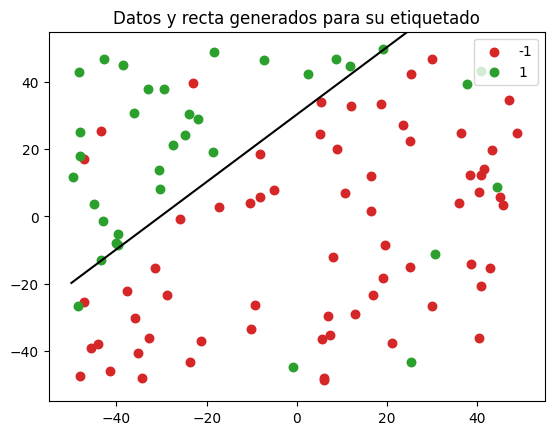

In [9]:
#Introduzco ruido
tags_ruido = introducir_ruido(tags, 10)

eClasi, porcError = clasifError(puntos, tags_ruido, a, b)

#Imprimo error
print('Misclassification rate: ', porcError, '%\n')

# Creo unas figura 
fig, ax = plt.subplots()

# Separamos los datos según su clase
puntos_tags = np.hstack((puntos, tags_ruido.reshape(-1, 1)))

bajo_f = puntos_tags[puntos_tags[:, -1] == -1]
sobre_f = puntos_tags[puntos_tags[:, -1] == 1]

# Visualizamos los datos con un Scatter plot
bajo_f_x = bajo_f[:, 0]
bajo_f_y = bajo_f[:, 1]
sobre_f_x = sobre_f[:, 0]
sobre_f_y = sobre_f[:, 1]

# Dibujamos los datos
ax.scatter(bajo_f_x, bajo_f_y, color='tab:red', marker = '.', s = 150)
ax.scatter(sobre_f_x, sobre_f_y, color='tab:green', marker = '.', s = 150)

# Dibujamos la recta de etiquetado
X = np.linspace(-50, 50, 100)
Y = a*X + b

ax.plot(X, Y, color=(.0, .0, .0))

# Acotamos las coordenadas de la gráfica
ax.set(xlim=(-55, 55), ylim=(-55, 55))

# Añadimos los títulos
ax.set_title('Datos y recta generados para su etiquetado')

# Añadimos la leyenda
ax.legend(('-1', '1'), loc='upper right')

plt.show()

En este caso como nos pedía el enunciado hemos introducido ruido en la muestra (10%), visualizando la gráfica podemos confirmar que ahora hay puntos mal clasificados, y mediante el cálculo del error en clasificación podemos confirmar que se trata del 10% que nos pedían. La recta dibujada es la misma función clasificadora original de la gráfica anterior, que no es que clasifique mal los datos, sino que son los datos los que vienen mal etiquetados(introducción de ruido).

#### <font color='blue'>c) (2.5 puntos)  Análisis y comparación de distintas fronteras de decisión. 
Supongamos ahora que las siguientes funciones definen la frontera de
clasificación de los puntos de la muestra en lugar de una recta.</font>

<font color='blue'>$f_1(x, y) = (x - 10)^2 + (y - 20)^2 - 400$</font>

<font color='blue'>$f_2(x, y) = 0.5(x + 10)^2 + (y - 20)^2 - 400$</font>

<font color='blue'>$f_3(x, y) = 0.5(x - 10)^2 - (y + 20)^2 - 400$</font>

<font color='blue'>$f_4(x, y) = y - 20x^2 - 5x + 3$</font>


<font color='blue'>

Visualizar el etiquetado generado en el Apartado (b) junto con la gráfica de cada
una de las funciones. Muéstrense los porcentajes de acierto en clasificación para las funciones (es decir, fronteras de decisión) evaluadas. Argumente si estas funciones más
complejas son mejores clasificadores que la función lineal. Observe las gráficas y diga
qué consecuencias extrae sobre la influencia de la modificación de etiquetas
en el proceso de aprendizaje. En concreto, razone sobre cuestiones como las siguientes: ¿Necesariamente funciones más complejas son mejores clasificadores (es decir, representan “mejores” bordes de decisión)? ¿Es posible superar/mejorar ese 10% de error de clasificación? ¿Qué pasa si repetimos el proceso con estas funciones más complejas (las empleamos para etiquetar los datos y luego metemos un 10% de ruido)? ¿Qué error de clasificación tenemos? ¿Es menor que ese 10%?
</font>



In [10]:
#Nuevas funciones frontera
def f1(x):
	return (x[:,0]-10)**2 + (x[:,1]-20)**2 - 400
 
def f2(x):
	return 0.5 * (x[:,0]+10)**2 + (x[:,1]-20)**2 - 400
 
def f3(x):
	return 0.5 * (x[:,0]-10)**2 - (x[:,1]+20)**2 - 400
 
def f4(x):
	return x[:,1] - 20*x[:,0]**2 - 5*x[:,0] + 3

In [11]:
# Error de clasificación para función f
# x = puntos/vector de características
# y = tags
def clasifError(x,y,f):
  fallos = 0
  tam_y = int(y.shape[0])

  y_estimado = f(x)

  for i in range(tam_y):
    if y[i] < 0 and y_estimado[i] > 0: 
      fallos = fallos+1
    elif y[i] > 0 and y_estimado[i] < 0:
      fallos = fallos+1

  return (fallos/tam_y)*100

In [12]:
"""
Esta función permite visualizar las fronteras de decisión.

Entradas: 
- X: datos de entrada con tantas filas como ejemplos, y tantas columnas como dimensiones/features
- y: etiquetas
- fz: función que define la frontera de decisión
- title: título que se le quiere poner a la figura
- xaxis: nombre que se le quiere poner al eje X
- yaxis: nombre que se le quiere poner al eje Y

Salida: visualización de los datos junto con la frontera de decisión proporcionada

Ejemplo de uso: 
def f_prueba(X):
	return X[:,0]**2 + X[:,1]**2 - 200
plot_datos_cuad(X, y, f_prueba, title=r'$f_{prueba}(x, y) = x^2 + y^2 - 200$')
"""
def plot_datos_cuad(X, y, fz, title='Point cloud plot', xaxis='x axis', yaxis='y axis'):
    #Preparar datos
    min_xy = X.min(axis=0)
    max_xy = X.max(axis=0)
    border_xy = (max_xy-min_xy)*0.01
    
    #Generar grid de predicciones
    # np.mgrid es una versión multidimensional de meshgrid (https://numpy.org/doc/stable/reference/generated/numpy.mgrid.html)
    xx, yy = np.mgrid[min_xy[0]-border_xy[0]:max_xy[0]+border_xy[0]+0.001:border_xy[0], 
                      min_xy[1]-border_xy[1]:max_xy[1]+border_xy[1]+0.001:border_xy[1]]
    # np.ravel "aplana" un array (https://numpy.org/doc/stable/reference/generated/numpy.ravel.html)
    # Diferencias entre ravel y flatten: https://stackoverflow.com/questions/28930465/what-is-the-difference-between-flatten-and-ravel-functions-in-numpy
    # np.c_ permite concatenar arrays a lo largo del segundo eje (https://numpy.org/doc/stable/reference/generated/numpy.c_.html)
    grid = np.c_[xx.ravel(), yy.ravel(), np.ones_like(xx).ravel()]
    pred_y = np.sign(fz(grid)).reshape(xx.shape)
    
    #Plot
    f, ax = plt.subplots(figsize=(8, 6))
    contour = ax.contourf(xx, yy, pred_y, 50, cmap='RdBu',vmin=-1, vmax=1)
    ax_c = f.colorbar(contour)
    ax_c.set_label('$f(x, y)$')
    ax_c.set_ticks([-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, linewidth=1, 
                cmap="RdYlBu", edgecolor='white')
    
    XX, YY = np.meshgrid(np.linspace(round(min(min_xy)), round(max(max_xy)),X.shape[0]),np.linspace(round(min(min_xy)), round(max(max_xy)),X.shape[0]))
    positions = np.vstack([XX.ravel(), YY.ravel()])
    # ax.contour(XX,YY,fz(positions.T).reshape(X.shape[0],X.shape[0]),[0], colors='white')
    
    ax.set(
       xlim=(min_xy[0]-border_xy[0], max_xy[0]+border_xy[0]), 
       ylim=(min_xy[1]-border_xy[1], max_xy[1]+border_xy[1]),
       xlabel=xaxis, ylabel=yaxis)
    plt.title(title)
    plt.show()

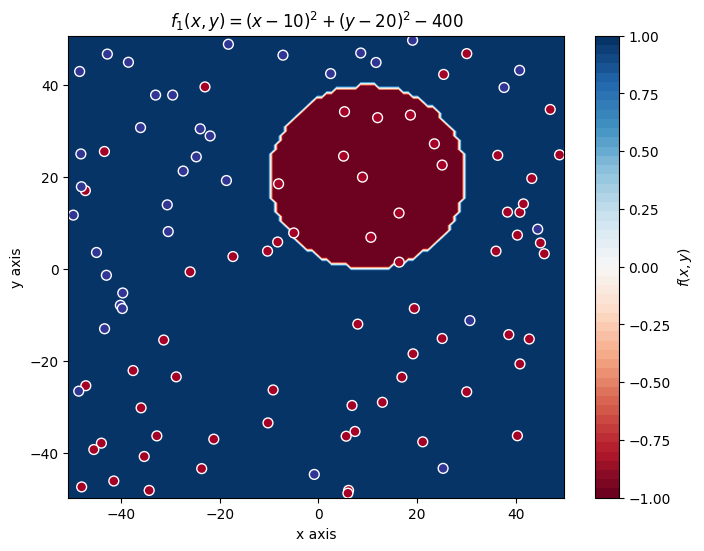

Misclassification rate:  53.0 %


In [13]:
#f_1
plot_datos_cuad(puntos, tags_ruido, f1, title=r'$f_{1}(x, y) = (x-10)^2 + (y-20)^2 - 400$')
print('Misclassification rate: ', clasifError(puntos, tags_ruido, f1) , '%')

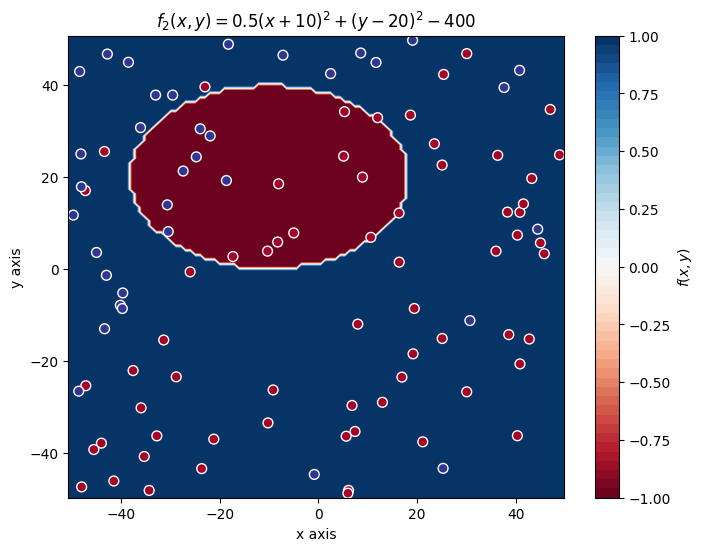

Misclassification rate:  63.0 %


In [14]:
#f_2
plot_datos_cuad(puntos, tags_ruido, f2, title=r'$f_{2}(x, y) = 0.5(x+10)^2 + (y-20)^2 - 400$')
print('Misclassification rate: ', clasifError(puntos, tags_ruido, f2) , '%')

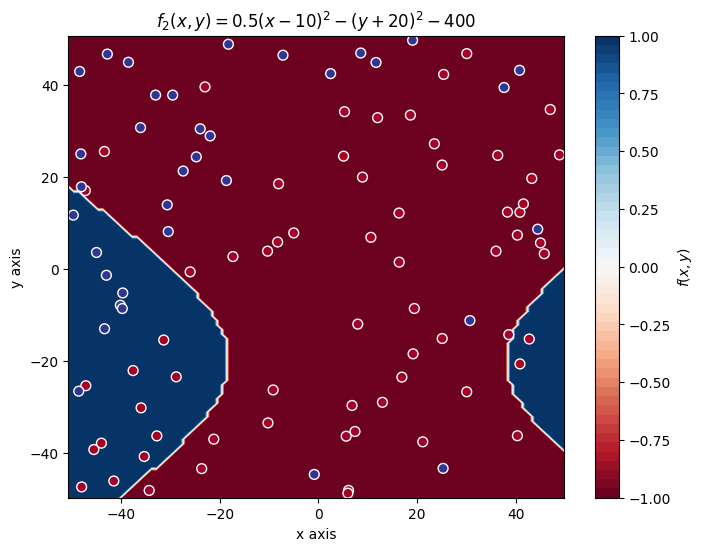

Misclassification rate:  40.0 %


In [15]:
#f_3
plot_datos_cuad(puntos, tags_ruido, f3, title=r'$f_{2}(x, y) = 0.5(x-10)^2 - (y+20)^2 - 400$')
print('Misclassification rate: ', clasifError(puntos, tags_ruido, f3) , '%')

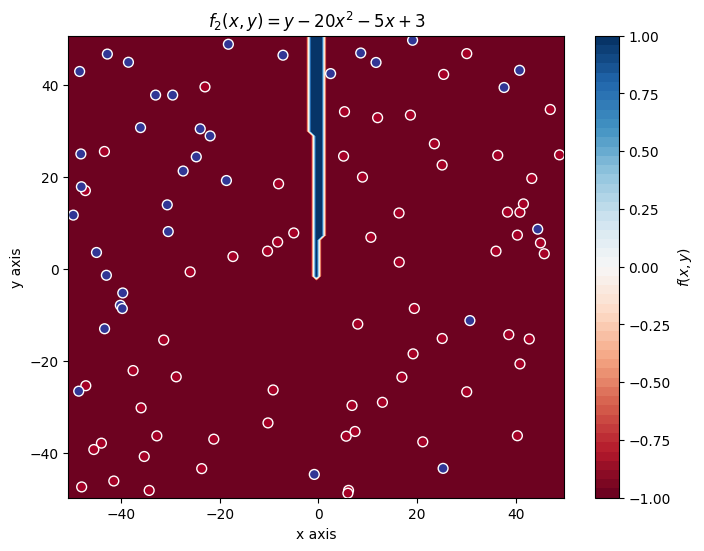

Misclassification rate:  35.0 %


In [16]:
#f_4
plot_datos_cuad(puntos, tags_ruido, f4, title=r'$f_{2}(x, y) = y - 20x^2 - 5x + 3$')
print('Misclassification rate: ', clasifError(puntos, tags_ruido, f4) , '%')

Por lo que podemos observar ninguna de estas funciones más complejas clasifica mejor los datos (la que mejor clasifica tiene un error de clasificación del 35%), esto se debe fundamentalmente a dos motivos, primero, estas son funciones no lineales, y como sabemos la función clasificadora original es una función lineal, por lo que ya de por sí intentar ajustar los datos no linealmente es un problema. El segundo motivo es que no entrenamos estas funciones para que se ajusten a nuestros datos, es decir estas funciones de por sí no tienen ninguna relación con los datos representados y en caso de clasificarlos bien sería una mera casualidad.

Podemos concluir en que a pesar de ser funciones más complejas estas no tienen por qué clasificar mejor el conjunto, incluso con la introducción de ruido impidiendo que este pueda ser separado linealmente.

No obstante si que podemos encontrar una función que tenga menos de un 10% de error de clasificación, una función no lineal la cual entrenemos con el conjunto de datos podrá llegar a clasificarlo mejor que la función original, el problema es que solo clasificará bien la muestra y a la hora de clasificar otros conjuntos de datos tendrá un error mayor, ya que esta función habrá sido sobreentrenada para clasificar bien un conjunto determinado de entrenamiento.

En cuanto al experimento de usar las funciones complejas como clasificadoras originales y luego aplicar el 10% de ruido en la muestra el resultado será el mismo que hemos tenido al hacer lo propio con nuestra función lineal, las funciones complejas clasificarán sus datos etiquetados con un 10% de error ya que les hemos introducido ese porcentaje de error tras etiquetar los datos, y es imposible que obtengamos valores de porcentaje de error en clasificación menores o distintos al 10% por esa misma razón.

## <font color='blue'>Ejercicio 2: MODELOS LINEALES (8 puntos) </font>

### <font color='blue'>Apartado 2.1 (3 puntos) Algoritmo Perceptrón (PLA). 

<font color='blue'>Implementar la función $ajusta\_PLA(datos, label, max\_iter, vini)$ que calcula el hiperplano solución a un problema de clasificación binaria usando el algoritmo PLA. La entrada $datos$ es una matriz donde cada ejemplo está representado por una fila de la matriz, $label$ el vector de etiquetas (cada etiqueta es
un valor +1 o -1), $max\_iter$ es el número máximo de iteraciones permitidas y $vini$
el valor inicial del vector. La función devuelve, como mínimo, los coeficientes del hiperplano y la iteración de convergencia.  </font>



In [17]:
def ajusta_PLA(datos, label, max_iter, vini):
  iters = 0
  actualiza = True

  while max_iter > iters and actualiza:
    actualiza = False

    #Comprobamos regla de actualización en todo el conjunto
    for i in range(label.size):
      aux = np.dot(vini.T, datos[i,:])

      #Actualizamos
      if label[i]*aux <= 0:
        vini = vini + label[i]*datos[i,:]
        actualiza = True

      #Acaba una iteración
      iters = iters+1
  
  return vini, iters

PLA es un algoritmo de aprendizaje supervisado utilizado para clasificación binaria. Funciona mediante la actualización iterativa de los pesos del modelo hasta que la clasificación sea correcta para todos los puntos de datos en el conjunto de entrenamiento.

Inicialmente, los pesos se establecen en valores aleatorios y se clasifican todos los puntos de datos. Si un punto de datos está clasificado incorrectamente, los pesos se actualizan según la dirección del vector normal a la superficie de decisión, de manera que el punto de datos se clasifica correctamente en la próxima iteración.

Los pros de PLA son que es simple y fácil de implementar, y puede funcionar bien en conjuntos de datos linealmente separables. Sin embargo, los contras son que no siempre converge en conjuntos de datos no linealmente separables, y puede ser muy lento para conjuntos de datos grandes o complejos.

Para el cálculo del PLA hay que calcular el h(x), para comprobar que clasifica bien la muestra:

$h(x) = sign((\sum_{i=1}^d w_i x_i)+w_0) = y_{n(t)} w_{(t)}^T x_{n(t)} \leq 0$

Con esto podemos saber si clasifica bien o no, para ello si h(x) es ≤ 0, significa que no lo hace, con lo cual habrá que actualizar w, siendo la regla de actualización de w:

$w_{new} = w_{old} + y_i x_i$

En caso de que sea > 0, quiere decir que clasifica bien ese dato de la muestra. 

<font color='blue'>Ejecutar el algoritmo PLA con los datos empleados en el Apartado (a) del Ejercicio 1. Inicializar el algoritmo con: 

<font color='blue'>i) el vector cero y, 

<font color='blue'>ii) con vectores de
números aleatorios en [0, 1] (10 veces). 

<font color='blue'>Anotar el número medio de iteraciones
necesarias en ambos para converger. Se deben mostrar en una tabla cada uno de los pesos iniciales empleados, los finales (obtenidos tras el proceso de entrenamiento), y el porcentaje de error de clasificación. También se debe visualizar una nube de puntos etiquetada junto con la frontera resultante del ajuste. Valorar el resultado relacionando el punto
de inicio con el número de iteraciones. </font>

In [18]:
#Función para hacer las gráficas
def my_plot_datos(puntos, tags_ruido, pesos, titulo, coord=[-55,55]):
  # Creo unas figura 
  fig, ax = plt.subplots()

  # Separamos los datos según su clase
  puntos_tags = np.hstack((puntos, tags_ruido.reshape(-1, 1)))

  bajo_f = puntos_tags[puntos_tags[:, -1] == -1]
  sobre_f = puntos_tags[puntos_tags[:, -1] == 1]

  # Visualizamos los datos con un Scatter plot
  bajo_f_x = bajo_f[:, 0]
  bajo_f_y = bajo_f[:, 1]
  sobre_f_x = sobre_f[:, 0]
  sobre_f_y = sobre_f[:, 1]

  # Dibujamos los datos
  ax.scatter(bajo_f_x, bajo_f_y, color='tab:red', marker = '.', s = 150)
  ax.scatter(sobre_f_x, sobre_f_y, color='tab:green', marker = '.', s = 150)

  # Dibujamos la recta de etiquetado
  X = np.linspace(coord[0], coord[1], 100)
  Y = (-pesos[0] - pesos[1]*X) / pesos[2]

  ax.plot(X, Y, color=(.0, .0, .0))

  # Acotamos las coordenadas de la gráfica
  ax.set(xlim=(coord[0], coord[1]), ylim=(coord[0], coord[1]))

  # Añadimos los títulos
  ax.set_title(titulo)

  # Añadimos la leyenda
  ax.legend(('-1', '1'), loc='upper right')

  plt.show()

In [19]:
# Error de clasificación para la recta y = w0 + w1*x1 + w2*x2
# w = los pesos
# x = los vectores de características del test
# y = el vector de etiquetas del test
def clasifError_PLA(w,x,y):
  predicted_y = x.dot(w)

  fallos = 0
  tam_y = int(y.shape[0])

  for i in range(tam_y):
    if predicted_y[i] < 0 and y[i] == 1: 
      fallos = fallos+1
    elif predicted_y[i] >= 0 and y[i] == -1: 
      fallos = fallos+1

  return (fallos/tam_y)*100

Misclassification rate:  0.0 %



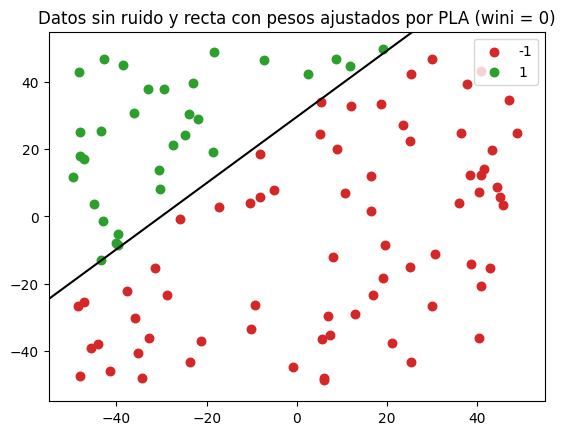

In [20]:
# i) Vector inicializado a 0
wini = np.array([0, 0, 0])

# Ajusto pesos con PLA
# Agregar una columna de unos como x_0
puntos_1 = np.insert(puntos, 0, 1, axis=1)

pesos_0, iters_0 = ajusta_PLA(puntos_1, tags, 150000, wini)

# Calculo error de clasificación
porcError_0 = clasifError_PLA(pesos_0, puntos_1, tags)
print('Misclassification rate: ', porcError_0, '%\n')

# Dibujo la gráfica
my_plot_datos(puntos, tags, pesos_0, 'Datos sin ruido y recta con pesos ajustados por PLA (wini = 0)')

En este experimento usando el conjunto de datos del ejercicio 1, usamos el algoritmo PLA para entrenar y ajustar los pesos de la frontera de decisión que se muestra en la gráfica, al ser el conjunto de datos linealmente separable PLA llega a la solución óptima, es decir, puede clasificar el conjunto sin error.


Misclassification rate( 0 ):  0.0 %



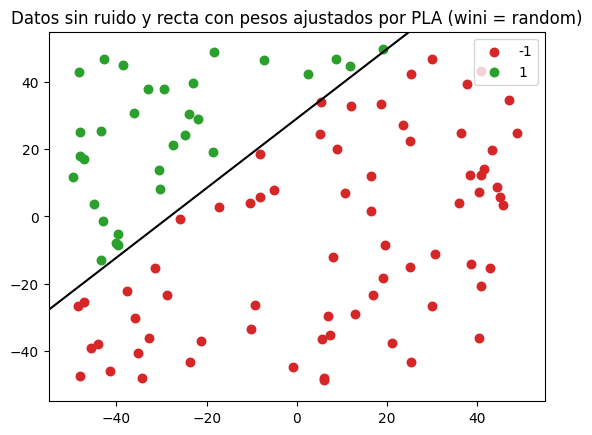


Misclassification rate( 1 ):  0.0 %



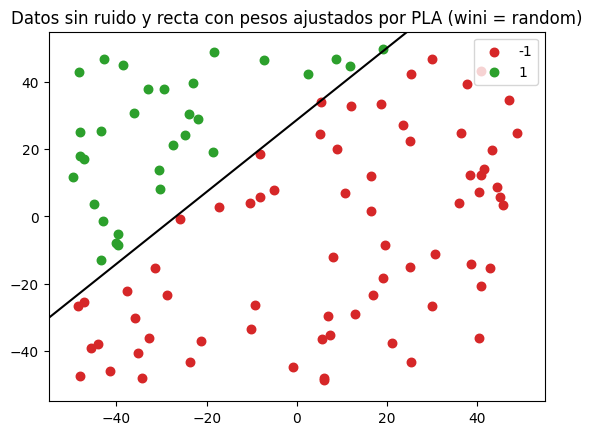


Misclassification rate( 2 ):  0.0 %



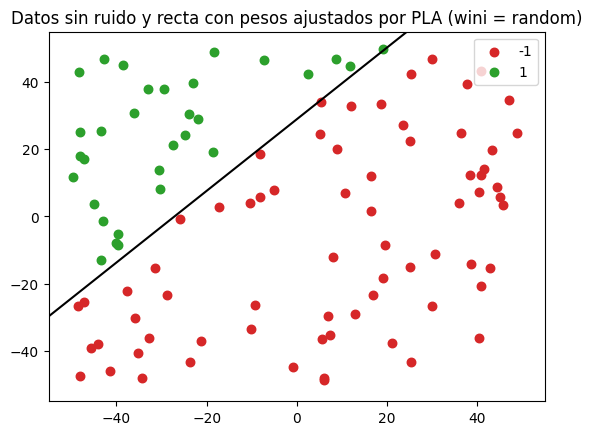


Misclassification rate( 3 ):  0.0 %



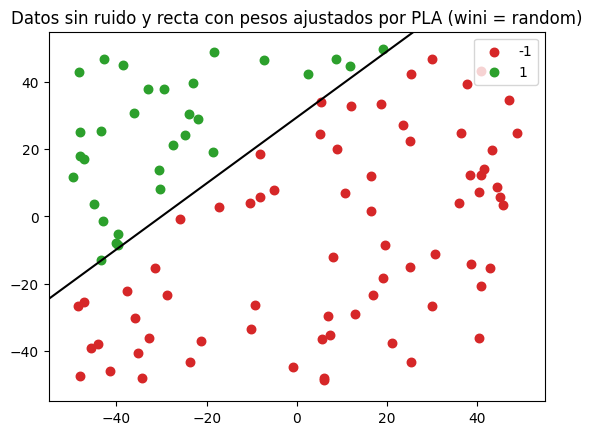


Misclassification rate( 4 ):  0.0 %



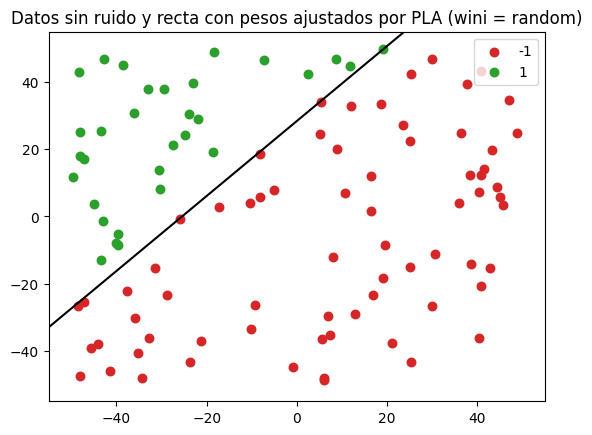


Misclassification rate( 5 ):  0.0 %



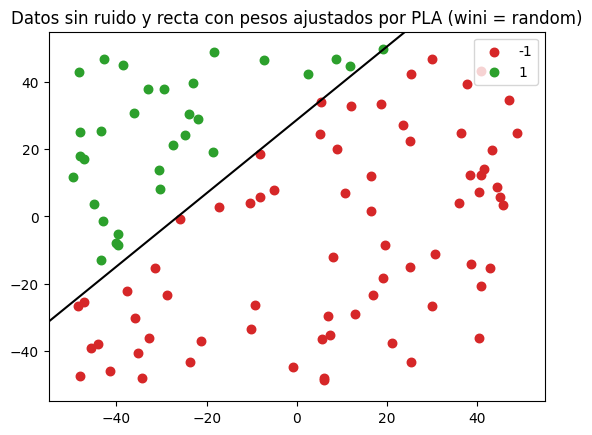


Misclassification rate( 6 ):  0.0 %



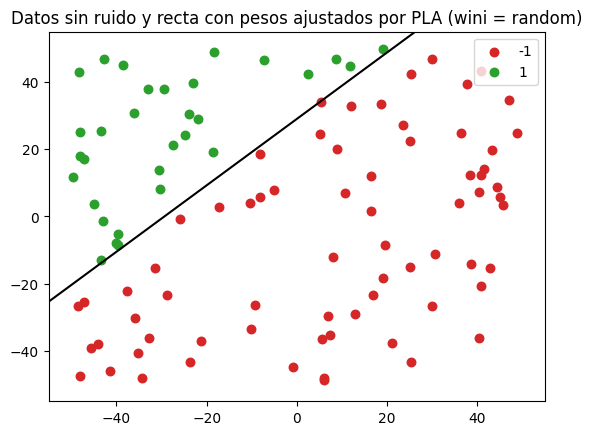


Misclassification rate( 7 ):  0.0 %



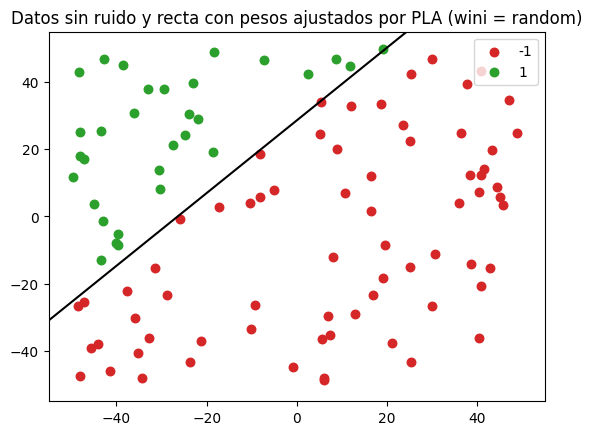


Misclassification rate( 8 ):  0.0 %



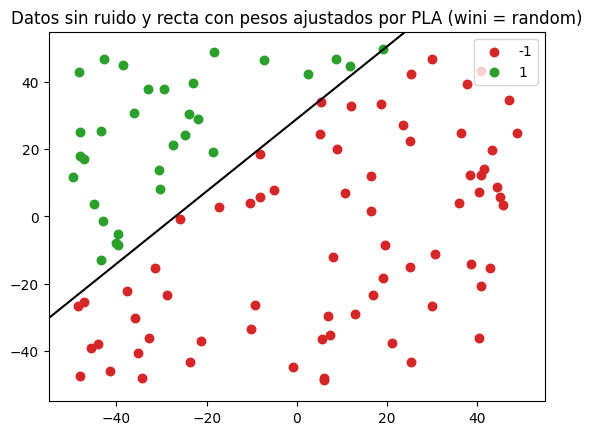


Misclassification rate( 9 ):  0.0 %



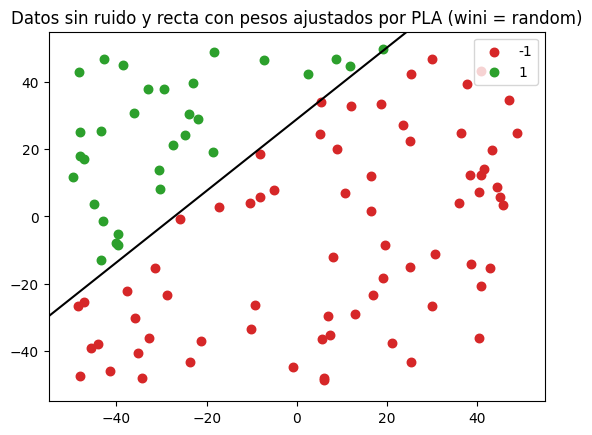

In [21]:
# ii) Vector inicializado aleatoriamente (10 veces)
wini_random = np.random.rand(10, 3)
pesos_random = np.zeros((10, 3))
iters_random = np.zeros(10)
pError_random = np.zeros(10)

for i in range(10):
  # Ajusto pesos con PLA
  pesos_random[i,:], iters_random[i] = ajusta_PLA(puntos_1, tags, 150000, wini_random[i,:])

  # Calculo error de clasificación
  pError_random[i] = clasifError_PLA(pesos_random[i,:], puntos_1, tags)
  print('\nMisclassification rate(', i, '): ', pError_random[i], '%\n')

  # Dibujo la gráfica
  my_plot_datos(puntos, tags, pesos_random[i,:], 'Datos sin ruido y recta con pesos ajustados por PLA (wini = random)')

A diferencia del ejemplo anterior aquí inicializamos los pesos a valores aleatorios en vez de a 0, seguimos encontrando la solución óptima por ser el conjunto linealmente separable, pero para cada uno de estos ejemplos el número de iteraciones será distinto como veremos a continuación, esto se debe al valor con el que inicialicemos los pesos.

In [22]:
#Mostramos los resultados
print('Pesos iniciales: ', wini, '              Pesos finales: ', np.round(pesos_0.astype(float), 2), '      Misclassification rate: ', porcError_0, '   Iteraciones hasta converger: ', iters_0, '\n')

for i in range(10):
  print('Pesos iniciales: ', np.round(wini_random[i,:].astype(float), 2), '  \tPesos finales: ', np.round(pesos_random[i,:].astype(float), 2), '  \tMisclassification rate: ', pError_random[i], ' \tIteraciones hasta converger: ', iters_random[i], '\n')

#Media de iteraciones
it_medias = iters_0

for i in range(10):
  it_medias = it_medias + iters_random[i]

print('Media de iteraciones hasta converger: ', it_medias/11)


Pesos iniciales:  [0 0 0]               Pesos finales:  [-587.    -19.5    19.79]       Misclassification rate:  0.0    Iteraciones hasta converger:  3400 

Pesos iniciales:  [0.62 0.43 0.97]   	Pesos finales:  [-1184.38   -42.02    40.61]   	Misclassification rate:  0.0  	Iteraciones hasta converger:  13800.0 

Pesos iniciales:  [0.68 0.2  0.43]   	Pesos finales:  [-1094.32   -40.77    38.07]   	Misclassification rate:  0.0  	Iteraciones hasta converger:  11000.0 

Pesos iniciales:  [0.34 0.8  0.88]   	Pesos finales:  [-574.66  -21.16   19.85]   	Misclassification rate:  0.0  	Iteraciones hasta converger:  3400.0 

Pesos iniciales:  [0.9  0.66 0.27]   	Pesos finales:  [-698.1   -23.24   23.66]   	Misclassification rate:  0.0  	Iteraciones hasta converger:  4400.0 

Pesos iniciales:  [0.25 0.85 0.53]   	Pesos finales:  [-1374.75   -53.98    48.39]   	Misclassification rate:  0.0  	Iteraciones hasta converger:  20900.0 

Pesos iniciales:  [0.8  0.57 0.73]   	Pesos finales:  [-782.2   -2

Podemos observar que contra mayor sea la diferencia que hay entre los pesos iniciales y los pesos finales más iteraciones necesitará PLA para converger, esto es basicamente porque la solución óptima está más lejos del punto inicial.

<font color='blue'>Ahora, hay que hacer lo mismo usando  los datos del Apartado (b) del Ejercicio 1, y $150.000$ como número máximo de iteraciones. ¿Se observa algún comportamiento diferente? En caso afirmativo, diga cuál y las
razones para que ello ocurra. </font>

Misclassification rate:  24.0 %



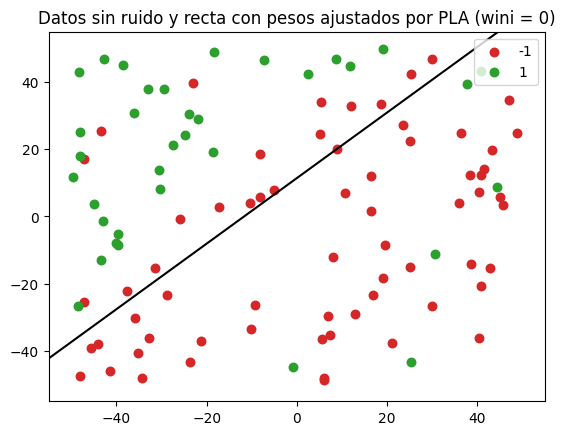

In [23]:
# i) Vector inicializado a 0
wini = np.array([0, 0, 0])

# Ajusto pesos con PLA
# Agregar una columna de unos como x_0
puntos_1 = np.insert(puntos, 0, 1, axis=1)

pesos_0, iters_0 = ajusta_PLA(puntos_1, tags_ruido, 150000, wini)

# Calculo error de clasificación
porcError_0 = clasifError_PLA(pesos_0, puntos_1, tags_ruido)
print('Misclassification rate: ', porcError_0, '%\n')

# Dibujo la gráfica
my_plot_datos(puntos, tags_ruido, pesos_0, 'Datos sin ruido y recta con pesos ajustados por PLA (wini = 0)')

Podemos observar que aquí PLA no clasifica tan bien, recordemos que estamos usando ahora la muestra con 10% de ruido, y no clasifica bien debido a que cuando el conjunto no es linealmente separable PLA nunca convergerá y se quedará en bucle hasta gastar el total de las iteraciones como veremos a continuación.


Misclassification rate( 0 ):  25.0 %



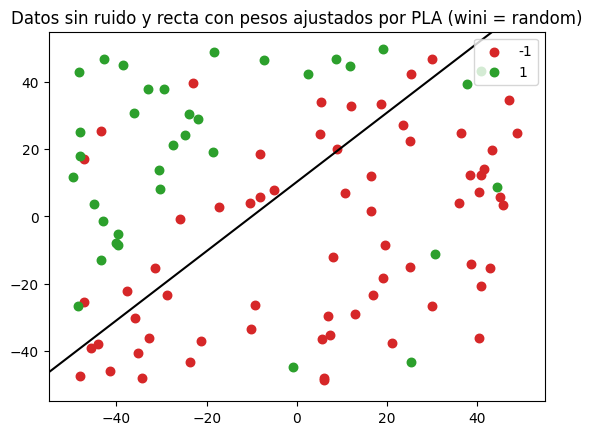


Misclassification rate( 1 ):  25.0 %



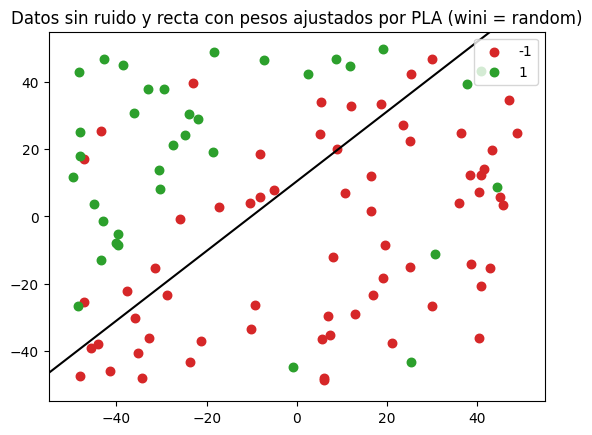


Misclassification rate( 2 ):  25.0 %



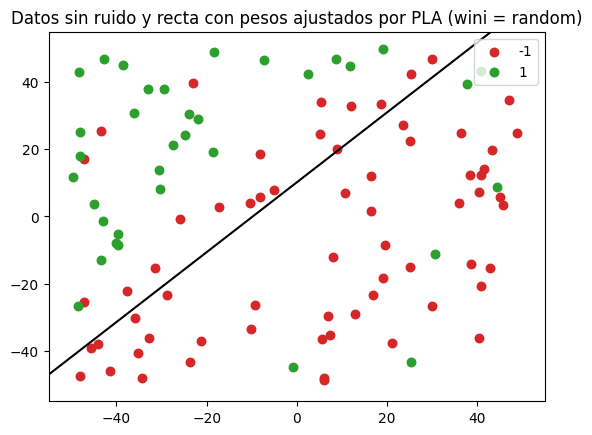


Misclassification rate( 3 ):  25.0 %



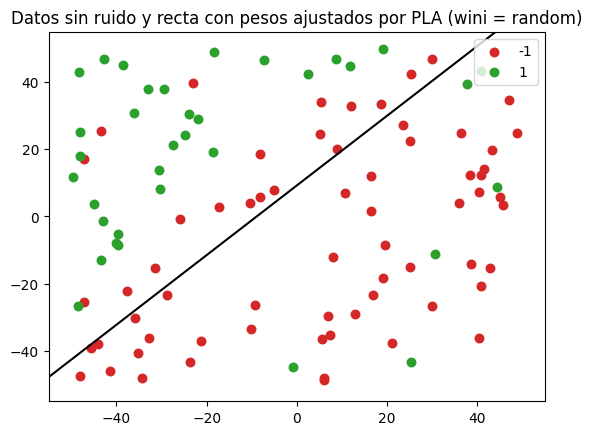


Misclassification rate( 4 ):  21.0 %



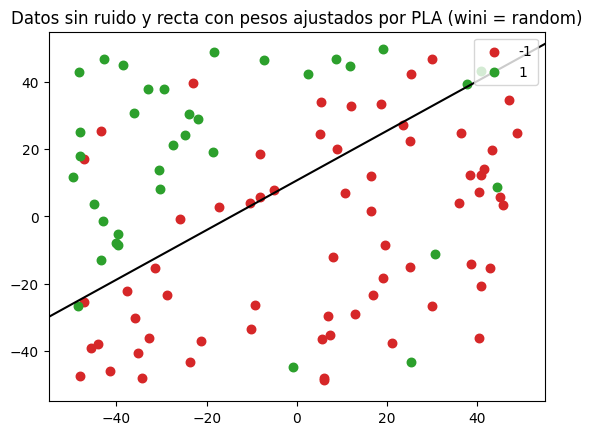


Misclassification rate( 5 ):  24.0 %



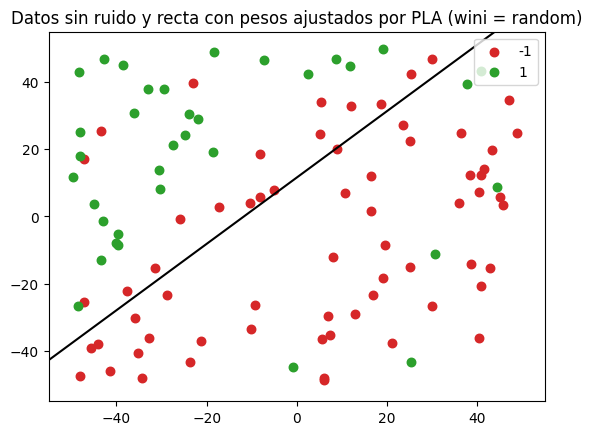


Misclassification rate( 6 ):  25.0 %



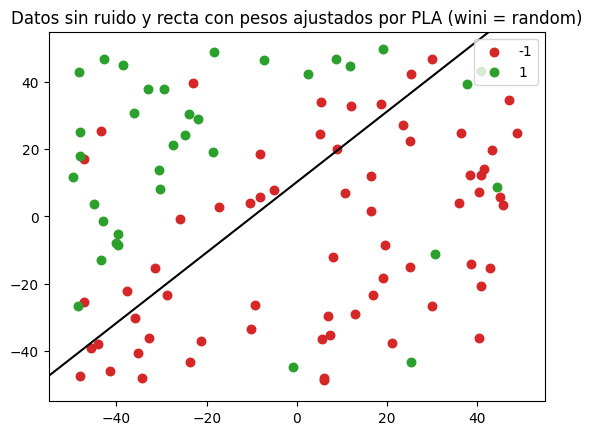


Misclassification rate( 7 ):  25.0 %



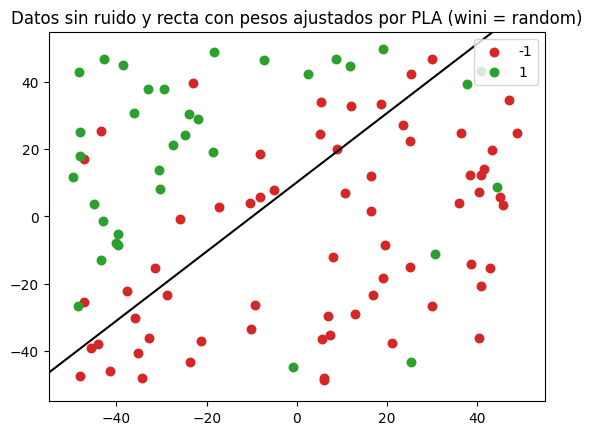


Misclassification rate( 8 ):  23.0 %



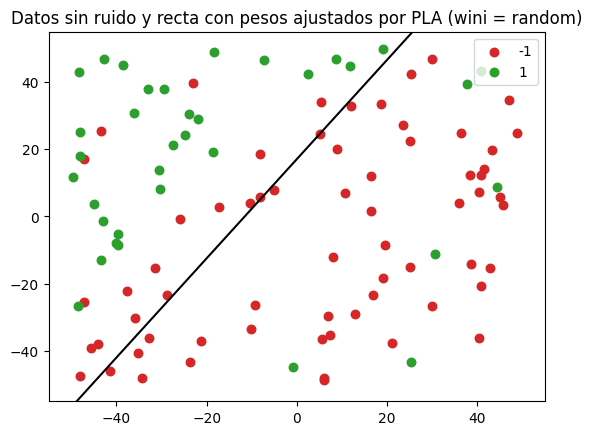


Misclassification rate( 9 ):  24.0 %



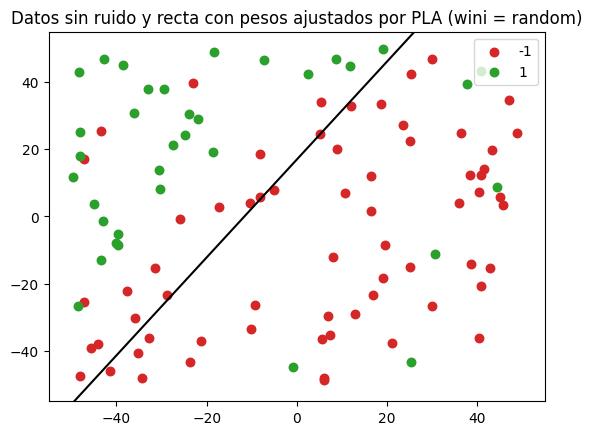

In [24]:
# ii) Vector inicializado aleatoriamente (10 veces)
wini_random = np.random.rand(10, 3)
pesos_random = np.zeros((10, 3))
iters_random = np.zeros(10)
pError_random = np.zeros(10)

for i in range(10):
  # Ajusto pesos con PLA
  pesos_random[i,:], iters_random[i] = ajusta_PLA(puntos_1, tags_ruido, 150000, wini_random[i,:])

  # Calculo error de clasificación
  pError_random[i] = clasifError_PLA(pesos_random[i,:], puntos_1, tags_ruido)
  print('\nMisclassification rate(', i, '): ', pError_random[i], '%\n')

  # Dibujo la gráfica
  my_plot_datos(puntos, tags_ruido, pesos_random[i,:], 'Datos sin ruido y recta con pesos ajustados por PLA (wini = random)')

En estos casos volvemos a utilizar valores aleatorios para inicializar los pesos, pero el error de clasificación sigue siendo alto, en torno al 24%.

In [25]:
#Mostramos los resultados
print('Pesos iniciales: ', wini, '              Pesos finales: ', np.round(pesos_0.astype(float), 2), '      Misclassification rate: ', porcError_0, '  Iteraciones hasta converger: ', iters_0, '\n')

for i in range(10):
  print('Pesos iniciales: ', np.round(wini_random[i,:].astype(float), 2), '  \tPesos finales: ', np.round(pesos_random[i,:].astype(float), 2), '  \tMisclassification rate: ', pError_random[i], ' \tIteraciones hasta converger: ', iters_random[i], '\n')

#Media de iteraciones
it_medias = iters_0

for i in range(10):
  it_medias = it_medias + iters_random[i]

print('Media de iteraciones hasta converger: ', it_medias/11)

Pesos iniciales:  [0 0 0]               Pesos finales:  [-731.    -62.41   64.  ]       Misclassification rate:  24.0   Iteraciones hasta converger:  150000 

Pesos iniciales:  [0.69 0.57 0.16]   	Pesos finales:  [-743.31  -74.3    72.12]   	Misclassification rate:  25.0  	Iteraciones hasta converger:  150000.0 

Pesos iniciales:  [0.47 0.35 0.23]   	Pesos finales:  [-755.53  -74.66   71.99]   	Misclassification rate:  25.0  	Iteraciones hasta converger:  150000.0 

Pesos iniciales:  [0.59 0.31 0.92]   	Pesos finales:  [-730.41  -74.63   71.77]   	Misclassification rate:  25.0  	Iteraciones hasta converger:  150000.0 

Pesos iniciales:  [0.91 0.26 0.11]   	Pesos finales:  [-721.09  -80.89   78.05]   	Misclassification rate:  25.0  	Iteraciones hasta converger:  150000.0 

Pesos iniciales:  [0.19 0.5  0.73]   	Pesos finales:  [-716.81  -49.29   66.76]   	Misclassification rate:  21.0  	Iteraciones hasta converger:  150000.0 

Pesos iniciales:  [0.21 0.25 0.85]   	Pesos finales:  [-713.7

Como comentaba antes para casos donde los datos no son linealmente separable PLA simplemente se queda actualizando sus pesos eternamente hasta agotar el número máximo de iteraciones, nunca obtendremos la solución óptima, no es capaz de conseguirla. Podemos ver que en todos los casos experimentados PLA gasta sus 150000 iteraciones y el error en clasificación se mantiene.

### <font color='blue'>Apartado 2.2 (5 puntos) Regresión Logística (RL). 


<font color='blue'>En este ejercicio emplearemos nuestra propia función
objetivo $f$ y un conjunto de datos $\mathcal{D}$ para ver cómo
funciona regresión logística. Consideraremos $d = 2$ para que los datos sean fácilmente visualizables, y emplearemos $\mathcal{X} = [0, 2] \times [0, 2]$ con
probabilidad uniforme de elegir cada $x \in \mathcal{X}$. Elegir una línea en el plano que pase por
$\mathcal{X}$ como la frontera que separa la región en donde $y$ toma valores +1 y -1. Para ello, seleccionar dos puntos aleatorios de $\mathcal{X}$ y calcular la línea
que pasa por ambos. 

<font color='blue'>Impleméntese RL con Gradiente Descendente Estocástico (SGD) del siguiente modo:

> <font color='blue'>1) Inicializar el vector de pesos con valores 0.

> <font color='blue'>2) Parar el algoritmo cuando $\|w^{(t+1)} - w^{(t)}\| < 0.01$, donde $w(t)$ denota el vector
de pesos al final de la época $t$. Recuérdese que una época es un pase completo a través de los $N$
ejemplos de nuestro conjunto de datos.

> <font color='blue'>3) Aplicar una permutación aleatoria de $\{1, 2,..., N\}$ a los índices de los datos, antes
de usarlos en cada época del algoritmo.

</font>


In [26]:
#SGD para Regresión Logística
def SGD_RL(x, y, w):
  return -(y*x/(1+np.exp(y*w.dot(x))))

def sgdRL(x, y, lr, tam_minibatch, max_epocas):
  #Inicializo pesos a 0
  w = np.zeros(3)
  w_ante = np.zeros(3)
  ep = 0

  while(ep < max_epocas):
    #Permutamos y seleccionamos un minibatch de la muestra
    random_perm = np.random.permutation(x.shape[0])
    random_perm = random_perm[0:tam_minibatch]

    #Calculamos el gradiente
    aux = 0
    for i in random_perm:
      aux = aux + SGD_RL(x[i],y[i],w) 

    w = w - lr * (aux/tam_minibatch) #Actualizamos pesos
    ep = ep+1

    #Comprobamos ||w(t-1) - wt|| < 0.01
    delta = np.linalg.norm(w_ante-w)
    if(delta < 0.01):
      return w, ep
    
    w_ante = np.copy(w)
  
  return w, ep

#Err = ln(1+e^(-yi*wi*xi))
def Err(x,y,w):
  resultado = np.float64(np.log(1+np.exp(-(x.dot(w) * y))))
  resultado.dtype = np.float64
  return resultado.mean()

# Error de clasificación para los pesos estimados
# x = puntos/vector de características
# y = etiquetas reales
# w = pesos
def clasifError(x,y,w):
  fallos = 0
  tam_y = int(x.shape[0])
  y_estimado = x.dot(w)
  
  for i in range(tam_y):
    if (y[i] == 1 and y_estimado[i] < 0) or (y[i] == -1 and y_estimado[i] >= 0): 
      fallos = fallos+1

  return (fallos/tam_y)*100

El algoritmo de regresión logística es un modelo de aprendizaje supervisado utilizado para la clasificación binaria. Dado un conjunto de datos etiquetados con dos clases diferentes, el objetivo del modelo es aprender una función que pueda predecir la clase de un nuevo ejemplo.

La regresión logística utiliza una función sigmoide para estimar la probabilidad de que una instancia pertenezca a una de las dos clases. La función sigmoide mapea cualquier valor de entrada a un valor entre 0 y 1. El modelo aprende los pesos para las características de entrada, multiplicando cada característica por un peso y luego sumándolos. El resultado de esta suma se introduce en la función sigmoide para calcular la probabilidad de pertenencia a una clase.

Durante el entrenamiento, se utiliza una función de pérdida para medir la diferencia entre la salida del modelo y la etiqueta verdadera. El objetivo es minimizar la función de pérdida ajustando los pesos del modelo utilizando un algoritmo de optimización, como el gradiente descendente.

Pros:

* Es un modelo simple y eficiente para la clasificación binaria
* Es fácil de interpretar y explicar
* Tiene un buen rendimiento en conjuntos de datos linealmente separables

Contras:

* No funciona bien en conjuntos de datos no linealmente separables
* Es sensible a características irrelevantes o redundantes en los datos
* No es adecuado para la clasificación multiclase

Para hacer el cálculo de regresión logística necesitamos calcular el gradiente:

$Δ E_{in} = -\frac{1}{N} \sum_{n=1}^N \frac{y_nx_n}{1+e^{y_nw^T(t)x_n}}$

Para el cálculo de regresión logística, básicamente consiste en ir actualizando los pesos, usando el Learning rate y el gradiente hasta que se ajuste bien a la muestra, tomando como criterio de parada que $||w_{old} − w|| < 0.01$

Para calcular el error en regresión logística usamos una función de pérdida, la más comúnmente utilizada y la que nosotros usaremos es la función de entropía cruzada:

$E_{in}(w) = \frac{1}{N} \sum_{n=1}^N In(1+e^{-y_nw^Tx_n})$

<font color='blue'>A continuación, empleando la implementación anterior, realícese el siguiente experimento:
 
> <font color='blue'>1) Seleccione $N = 100$ puntos aleatorios $\{{\bf x}_n \}$ de $\mathcal{X}$ y evalúe las
respuestas $\{y_n\}$ de todos ellos respecto de la frontera elegida. 

> <font color='blue'>2) Ejecute RL para encontrar la función solución $g$. Visualice la frontera de decisión encontrada, y muestre el $E_{in}$ y el porcentaje de acierto en clasificación correspondientes. Se debe escoger experimentalmente tanto el $\textit{learning rate}$ (tasa de aprendizaje $\eta$) como el tamaño de batch. 

> <font color='blue'>3) Evalúe el error $E_{out}$ usando para ello una nueva muestra de datos ($>999$).  Muéstrense, de nuevo, tanto el ajuste visual, como el $E_{out}$ y el porcentaje de acierto en test. 

> <font color='blue'>4) Repita el experimento anterior (pasos 1-3) $50$ veces, y calcule los valores promedio de $E_{in}$ y $E_{out}$, de porcentaje de error de clasificación (en entrenamiento y test), y de épocas necesarias para converger (en entrenamiento).   

<font color='blue'>Junto con la realización del experimento anteriormente descrito, discuta qué ocurriría si, como criterio de parada, se emplease la diferencia entre pesos obtenidos en sucesivas iteraciones (en lugar de en sucesivas épocas). Del mismo modo, explique cómo ha escogido el $\textit{learning rate}$ y el $\textit{batch size}$, y las conclusiones que extrae al respecto (por ejemplo, ¿valores de $\textit{learning rate}$ como 0.001, cuando se emplea la diferencia de pesos entre épocas como criterio de terminación, funcionan adecuadamente y permiten resolver el problema?). 




Numero de aciertos en clasificacion:  100.0 %
Ein =  0.06023087935478725


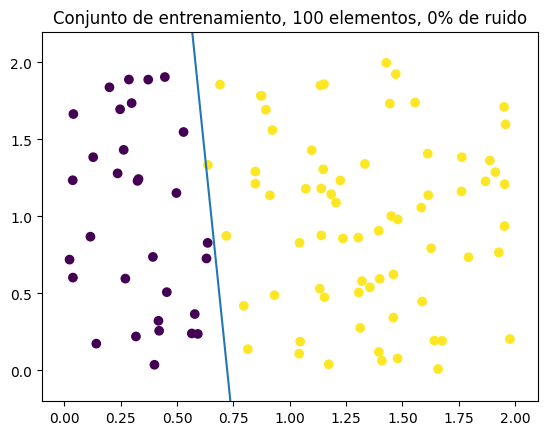

In [27]:
np.random.seed(0)

intervalo = [0,2]

puntos = simula_unif(100, 2, intervalo)

#Genero la recta con los puntos aleatorios
a, b = simula_recta(intervalo)

#Etiqueto con la función que se daba en el ejercicio 1 que hacía uso de la pendiente y el término independiente
tags = np.zeros(100)

for i in range(100):
  tags[i] = f(puntos[i, 0], puntos[i, 1], a, b)

#Calculo los pesos con RL
#Agregar una columna de unos como x_0
puntos_1 = np.insert(puntos, 0, 1, axis=1)
w, ep = sgdRL(puntos_1, tags, 1.5, 36, 150000)
print("Numero de aciertos en clasificacion: ", 100 - clasifError(puntos_1, tags, w), "%")
print("Ein = ",Err(puntos_1, tags, w))

#Dibujamos la gráfica
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(puntos_1[:,1], puntos_1[:,2], c=tags)

#Dibujamos la frontera de decisión
X = np.linspace(0, 2, tags.size)
Y = (-w[0]-w[1]*X)/w[2]
ax.plot(X, Y)
ax.set_title('Conjunto de entrenamiento, 100 elementos, 0% de ruido')
ax.set_ylim((-0.2, 2.2))
plt.show()

En este experimento creamos una nueva nube de 100 puntos y los etiquetamos con una recta aleatoria, a continuación mediante RL ajustamos los pesos para obtener una frontera de decisión que clasifique los datos de forma óptima, empiezo usando un learning rate de 0.1, ya que es bueno empezar probando con valores pequeños de este y luego ir aumentandolo y un minibatch de 32 datos, ya que según la teoría un buen minibatch está entre 24 y 64 datos, con estos parámetros obtengo un acierto en clasificación del 73%, LR solo gasta 82 épocas por lo que termina porque la diferencia entre pesos al actualizar es ya muy pequeña, esto puede deberse a que el learning rate es muy bajo, va convergiendo muy lentamente (saltos pequeños) y termina antes de llegar al óptimo.

Cambio el learning rate a 0.5 y el porcentaje de aciertos aumenta al 98%, RL consume ahora 269 épocas, por lo que sigue terminando porque la diferencia de pesos es muy pequeña antes de converger al óptimo.

Tras hacer varias pruebas ajustando el learning rate me sigo manteniendo en un 98% de aciertos, por lo que decido dejarlo en 0.5 y modificar el tamaño del minibatch para ver si con algunos datos de más consigue converger en el óptimo, elijo un minibatch de 36 ejemplos y consigo que el porcentaje de aciertos sea del 99%, vuelvo a modificar el learning rate y para uno de 1.5 consigo el 100% de aciertos en clasificación.

En cuanto al $E_{in}$ final este es muy bajo, de 0.06, por lo que tenemos otro indicativo de que hemos ajustado bien los datos.

Numero de aciertos en clasificacion:  98.9 %
Eout =  0.07355237330009066


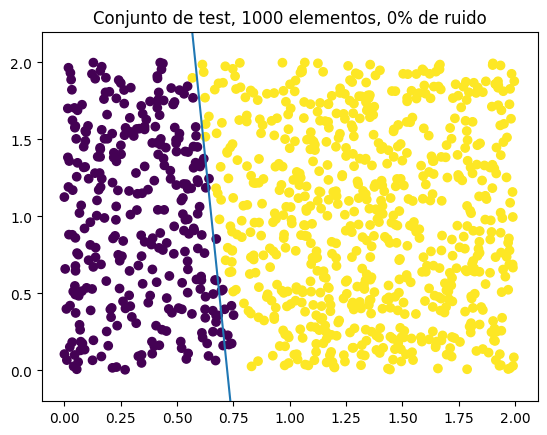

In [28]:
puntos_test = simula_unif(1000, 2, intervalo)

#Etiqueto con la función que se daba en el ejercicio 1 que hacía uso de la pendiente y el término independiente
tags_test = np.zeros(1000)

for i in range(1000):
  tags_test[i] = f(puntos_test[i, 0], puntos_test[i, 1], a, b)

#Agregar una columna de unos como x_0
puntos_1_test = np.insert(puntos_test, 0, 1, axis=1)

print("Numero de aciertos en clasificacion: ", 100 - clasifError(puntos_1_test, tags_test, w), "%")
print("Eout = ",Err(puntos_1_test, tags_test, w))

#Dibujamos la gráfica
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(puntos_1_test[:,1], puntos_1_test[:,2], c=tags_test)

#Dibujamos la frontera de decisión
X = np.linspace(0, 2, tags_test.size)
Y = (-w[0]-w[1]*X)/w[2]
ax.plot(X, Y)
ax.set_title('Conjunto de test, 1000 elementos, 0% de ruido')
ax.set_ylim((-0.2, 2.2))
plt.show()

Para comprobar si la función ajustada es buena con otros datos que no sean del conjunto de entrenamiento creo otra nube de puntos aleatoria, 1000, y compruebo cual es el acierto en clasificación de mi función con estos datos, este es del 98.9%, por lo que nuestra función no está sobreajustada a los datos de entrenamiento y es buena para cualquier conjunto de datos etiquetado por la recta aleatoria que seleccionamos antes.

En cuanto al $E_{out}$, también es bueno 0.07, lo cual es otro indicativo de lo que ya he dicho, que esta función es buena para cualquier conjunto de datos.

Haber conseguido una función clasificadora óptima para este conjunto de datos ha sido fácil con RL, ya que esta es buena para conjuntos de datos linealmente separables y acaba convergiendo en el óptimo con los parámetros adecuados.

In [29]:
#Repetimos todo el experimento 50 veces
np.random.seed(0)

Ein = 0
Eout = 0
err_clasi_train = 0
err_clasi_test = 0
ep = 0

for i in range(50):
  #Training
  puntos = simula_unif(100, 2, intervalo)

  #Etiqueto con la función que se daba en el ejercicio 1 que hacía uso de la pendiente y el término independiente
  tags = np.zeros(100)

  for i in range(100):
    tags[i] = f(puntos[i, 0], puntos[i, 1], a, b)

  #Calculo los pesos con RL
  #Agregar una columna de unos como x_0
  puntos_1 = np.insert(puntos, 0, 1, axis=1)
  w, ep_aux = sgdRL(puntos_1, tags, 15, 75, 150000)
  err_clasi_train = err_clasi_train + clasifError(puntos_1, tags, w)
  Ein = Ein + Err(puntos_1, tags, w)
  ep = ep + ep_aux

  #Test
  puntos_test = simula_unif(1000, 2, intervalo)

  #Etiqueto con la función que se daba en el ejercicio 1 que hacía uso de la pendiente y el término independiente
  tags_test = np.zeros(1000)

  for i in range(1000):
    tags_test[i] = f(puntos_test[i, 0], puntos_test[i, 1], a, b)

  #Agregar una columna de unos como x_0
  puntos_1_test = np.insert(puntos_test, 0, 1, axis=1)

  err_clasi_test = err_clasi_test + clasifError(puntos_1_test, tags_test, w)
  Eout = Eout + Err(puntos_1_test, tags_test, w)

print("Errores en clasificacion medio para training: ", err_clasi_train/50, "%")
print("Ein medio = ", Ein/50)
print("Errores en clasificacion medio para test: ", err_clasi_test/50, "%")
print("Eout medio = ", Eout/50)
print("Epocas medias hasta converger: ", ep/50)

Errores en clasificacion medio para training:  0.04 %
Ein medio =  0.01952920340676993
Errores en clasificacion medio para test:  0.9480000000000001 %
Eout medio =  0.030800854737926597
Epocas medias hasta converger:  1452.7


Ahora repetimos el experimento 50 veces, de primeras uso los mismos parámetros deducidos del caso anterior para RL, learning rate de 1.5 y minibatch de 36, obtengo un error en clasificación del 1.06%, bajo pero no suficiente, ya que hemos visto que este puede ser nulo, por lo que empiezo a modificar los parámetros.

Tras varias pruebas aumentando el minibatch para aprender mejor de la muestra, pero sin pasarme y aumentando el learning rate para dar mayores saltos a la hora de converger y que la diferencia entre pesos sea mayor y así que no termine RL antes de alcanzar el óptimo consigo un error en clasificación de 0.04% y un $E_{in} = 0.02$, para un learning rate igual a 15 y un minibatch de tamaño 75. 

El resultado sigue sin ser óptimo pero al tratarse de 50 nubes de puntos distintas los parámetros que mejoran algunos casos pueden no ser tan buenos con otros casos, podría haber seleccionado el total de la muestra como minibatch para conseguir el 100% de acierto en clasificación, ya que en este caso no hay ruido y por tanto no existirá nunca un sobreajuste de los pesos, sin embargo en un caso real esto no lo sabemos y es muy poco usual, por lo que seleccionar toda la muestra como minibatch no es una práctica recomendable.

Una vez decididos nuestro learning rate y minibatch definitivos vemos que valores tenemos para el $E_{out}$ y el error en clasificación con un nuevo conjunto de test, estos son 0.03 y 0.95% respectivamente, son buenos datos aunque de nuevo no óptimos y peores que sus homólogos para el conjunto de entrenamiento, esto se debe a que al añadir nuevos y más puntos (1000), los que se generen cerca de la frontera de decisión pueden ser mal clasificados ya que esta no está perfectamente ajustada.

Concluyendo podemos observar que al tener como criterio de parada que la diferencia de pesos sea < 0.01, no siempre llegamos a converger en el punto óptimo, en el caso de comprobar esta diferencia de pesos en cada iteración en vez de en cada época esta será mucho menor, ya que en cada iteración los pesos se actualizan muy poco a poco y no es hasta que acaba la época que todas estas pequeñas actualizaciones se suman y se compara con los valores de los pesos de la época anterior. En dicho caso deberíamos poner un umbral de diferencia mucho menor a 0.01 o de lo contrario el algoritmo finalizara sin haber actualizado los pesos.

En cuanto al uso de valores pequeños para el learning rate, como he comentado anteriormente debido al criterio de parada establecido estos no son buenos ya que contra más pequeño el learning rate, menores serán las actualizaciones de pesos en cada época y por tanto antes finalizará el algoritmo.

<font color='blue'>Ahora repita el mismo experimento, pero empleando datos no linealmente separables. Para ello, debe introducirse un 10% de ruido por clase. 

Errores en clasificacion medio para training:  13.66 %
Ein medio =  0.4086622337450707
Errores en clasificacion medio para test:  14.232000000000001 %
Eout medio =  0.4258419329102845
Epocas medias hasta converger:  3616.64


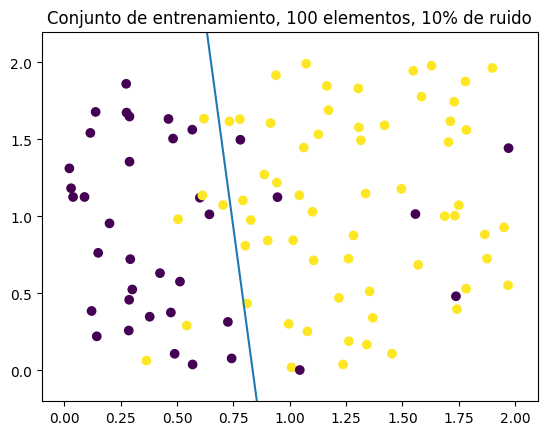

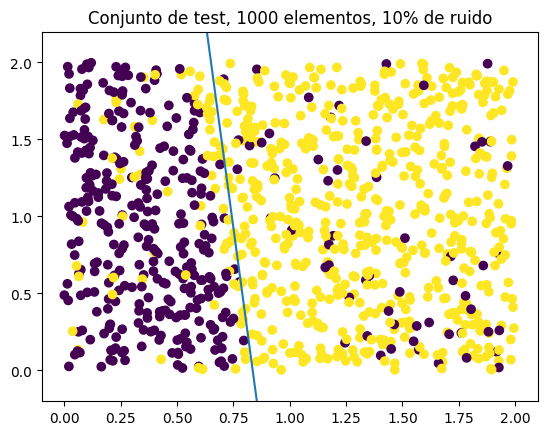

In [30]:
np.random.seed(0)

intervalo=[0,2]

#Repetimos todo el experimento 50 veces con ruido
Ein = 0
Eout = 0
err_clasi_train = 0
err_clasi_test = 0
ep = 0

for i in range(50):
  #Training
  puntos = simula_unif(100, 2, intervalo)

  #Etiqueto con la función que se daba en el ejercicio 1 que hacía uso de la pendiente y el término independiente
  tags = np.zeros(100)

  for i in range(100):
    tags[i] = f(puntos[i, 0], puntos[i, 1], a, b)

  #Agrego ruido
  tags_ruido = introducir_ruido(tags, 10)

  #Calculo los pesos con RL
  #Agregar una columna de unos como x_0
  puntos_1 = np.insert(puntos, 0, 1, axis=1)
  w, ep_aux = sgdRL(puntos_1, tags_ruido, 1, 10, 75000)
  err_clasi_train = err_clasi_train + clasifError(puntos_1, tags_ruido, w)
  Ein = Ein + Err(puntos_1, tags_ruido, w)
  ep = ep + ep_aux

  #Test
  puntos_test = simula_unif(1000, 2, intervalo)

  #Etiqueto con la función que se daba en el ejercicio 1 que hacía uso de la pendiente y el término independiente
  tags_test = np.zeros(1000)

  for i in range(1000):
    tags_test[i] = f(puntos_test[i, 0], puntos_test[i, 1], a, b)

  #Agrego ruido
  tags_test_ruido = introducir_ruido(tags_test, 10)

  #Agregar una columna de unos como x_0
  puntos_1_test = np.insert(puntos_test, 0, 1, axis=1)

  err_clasi_test = err_clasi_test + clasifError(puntos_1_test, tags_test_ruido, w)
  Eout = Eout + Err(puntos_1_test, tags_test_ruido, w)

print("Errores en clasificacion medio para training: ", err_clasi_train/50, "%")
print("Ein medio = ", Ein/50)
print("Errores en clasificacion medio para test: ", err_clasi_test/50, "%")
print("Eout medio = ", Eout/50)
print("Epocas medias hasta converger: ", ep/50)

#Dibujamos la gráfica con los valores de la última iteración
#Training
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(puntos_1[:,1], puntos_1[:,2], c=tags_ruido)

#Dibujamos la frontera de decisión
X = np.linspace(0, 2, tags_ruido.size)
Y = (-w[0]-w[1]*X)/w[2]
ax.plot(X, Y)
ax.set_title('Conjunto de entrenamiento, 100 elementos, 10% de ruido')
ax.set_ylim((-0.2, 2.2))
plt.show()

#Test
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(puntos_1_test[:,1], puntos_1_test[:,2], c=tags_test_ruido)

#Dibujamos la frontera de decisión
X = np.linspace(0, 2, tags_test_ruido.size)
Y = (-w[0]-w[1]*X)/w[2]
ax.plot(X, Y)
ax.set_title('Conjunto de test, 1000 elementos, 10% de ruido')
ax.set_ylim((-0.2, 2.2))
plt.show()

Ahora repetimos el último experimento pero introduciendo ruido en nuestra muestra, debido a la introducción del ruido reduzco el valor inicial del minibatch a 36 para evitar sobreajustes, el learning rate lo mantengo en 15 igual que ha acabado en el anterior experimento. Obtenemos un 14% de error en clasificación, reduzco algo más el minibatch, pero veo que los resultados se mantienen iguales, lo aumento y lo mismo, por lo que lo dejo en tamaño 36 y procedo a cambiar el learning rate. 

Primero lo aumento un poco a ver si consigo que converja más cerca del óptimo antes de que el algoritmo finalice, pero sin que empiece a diverger por ser demasiado grande, sigo teniendo un 14% de error, por lo que pruebo a reducirlo, esto ya más por probar, ya que no veo razón lógica para que vaya mejor con un learning rate menor, y en efecto el error en clasificación aumenta ligerísimamente a un 14.000000000000002%, por lo que llego a la conclusión de que poco se puede mejorar ese error en clasificación y dejo los parámetros como estaban al principio.

Un inciso que he de hacer es que estos resultados se corresponden con la repetición del experimento una única vez, y no 50 veces, ya que en cada iteración tarda unos 33s, por lo que en 50 tardará unos 25 minutos y para probar distintas combinaciones de parámetros es más rápido así.

Tras ejecutar las 50 veces el experimento veo que los resultados son malos, 24% de error en clasificación, caigo en la cuenta de que haber elegido los parámetros teniendo en cuenta una única ejecución del experimento es lo que ha influido en los malos resultados para todas las ejecuciones, por lo que elijo un minibatch y un learning rate mucho menores (10, 0.25) para ejecutar el experimento completo y que no tarde tanto tiempo, obtengo un error del 19%, por lo que decido aumentar el learning rate hasta 1 para que RL converja hasta valores más óptimos, y en efecto con esta configuración consigo un error del 13.66% y un $E_{in} = 0.4$, teniendo en cuenta el 10% de ruido son resultados muy buenos.

A la hora de probar nuestra frontera con datos de fuera de la muestra obtenemos los siguientes resultados, un error en clasificación del 14.23% y un $E_{out} = 0.43$, se confirma que el ajuste clasifica bien para cualquier conjunto y no únicamente para la muestra.



---

## <font color='blue'> Bonus (1.5 puntos). Clasificación de dígitos.

El BONUS solo se tendrá en cuenta si se ha obtenido al menos el 75\% de los puntos de la
parte obligatoria.</font>

<font color='blue'>Considerar el conjunto de datos de dígitos manuscritos, y seleccionar las muestras de los dígitos 4 y 8. Extraer las características de intensidad promedio y simetría en la manera que se indicó en la práctica anterior.
</font>

<font color='blue'> 1) Plantear un problema de clasificación binaria que considere el conjunto de entrenamiento
como datos de entrada para aprender la función $g$.

<font color='blue'> 2) Compárense los modelos de regresión lineal, PLA, RL y PLA-Pocket. 

> <font color='blue'> a) Generar gráficos separados de los datos de entrenamiento y test junto con
la función estimada.

> <font color='blue'> b) Calcular $E_{in}$ y $E_{test}$ (error sobre los datos de test).

> <font color='blue'> c) Si se emplean los pesos obtenidos con regresión lineal para inicializar los otros tres métodos (RL, PLA, PLA-pocket), ¿se observa alguna mejora en los resultados a algún nivel? Justifique su respuesta.

> <font color='blue'> d) Obtener cotas sobre el verdadero valor de $E_{out}$ para los cuatro métodos empleados. Calcúlense dos cotas: una
basada en $E_{in}$ y otra basada en $E_{test}$. Usar una tolerancia $\delta = 0.05$. ¿Qué cota es
mejor? Justifique la respuesta.  


In [31]:
#Para acceder a nuestros ficheros de Google Drive
from google.colab import drive
drive.mount('/content/drive')
# La carpeta datos (que contiene X_train.npy, y_train.npy, X_test.npy y y_test.npy) 
# debe estar en vuestro Drive, dentro de la carpeta 'Colab Notebooks'

Mounted at /content/drive


In [32]:
# Funcion para leer los datos
def readData(file_x, file_y, class1, class2, label_class1, label_class2):
    # Leemos los ficheros    
    datax = np.load(file_x)
    datay = np.load(file_y)
    y = []
    x = []    
    # Solo guardamos los datos de las dos clases que nos interesan
    for i in range(0,datay.size):
        if datay[i] == class1 or datay[i] == class2:
            if datay[i] == class1:
                y.append(label_class1)
            else:
                y.append(label_class2)
            x.append(np.array([1, datax[i][0], datax[i][1]]))
            
    x = np.array(x, np.float64)
    y = np.array(y, np.float64)
    
    return x, y

In [33]:
class1 = 8 #dígito 8
class2 = 4 #dígito 4
label1 = 1 #etiqueta empleada para representar class1
label2 = -1 #etiqueta empleada para representar class2
# Lectura de los datos de entrenamiento 
x, y = readData('drive/MyDrive/Colab Notebooks/datos/X_train.npy', 
                'drive/MyDrive/Colab Notebooks/datos/y_train.npy', class1, class2, label1, label2)
# Lectura de los datos para el test
x_test, y_test = readData('drive/MyDrive/Colab Notebooks/datos/X_test.npy', 
                          'drive/MyDrive/Colab Notebooks/datos/y_test.npy', class1, class2, label1, label2)

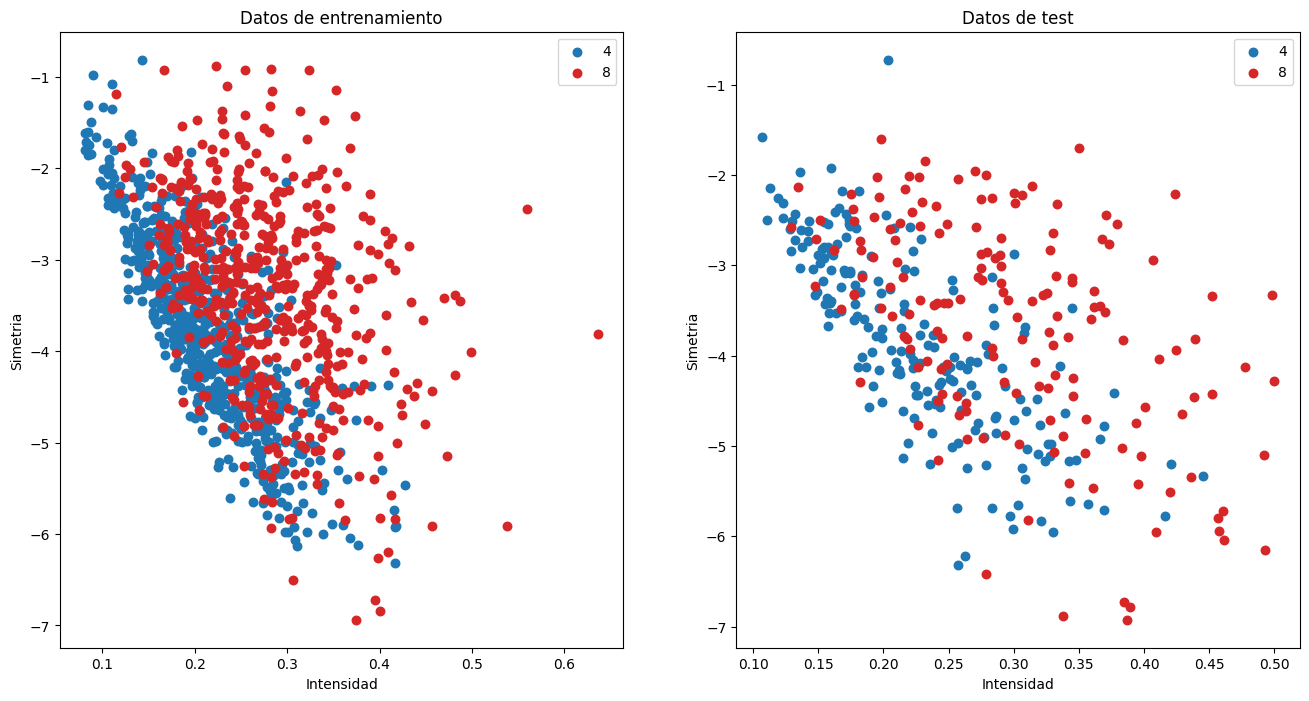

In [34]:
#Dibujamos el conjunto de datos para poder visualizarlo
# Creo unas figura 
fig = plt.figure(figsize=(16,8))

# Separamos los datos según su clase
x_y = np.hstack((x, y.reshape(-1, 1)))

cuatro = x_y[x_y[:, -1] == -1]
ocho = x_y[x_y[:, -1] == 1]

# Visualizamos los datos con un Scatter plot
cuatro_inten = cuatro[:, 1]
cuatro_sime = cuatro[:, 2]
ocho_inten = ocho[:, 1]
ocho_sime = ocho[:, 2]

ax = fig.add_subplot(1, 2, 1)

# Dibujamos los datos
ax.scatter(cuatro_inten, cuatro_sime, color='tab:blue', marker = '.', s = 150)
ax.scatter(ocho_inten, ocho_sime, color='tab:red', marker = '.', s = 150)

# Añadimos los títulos
ax.set_xlabel('Intensidad')
ax.set_ylabel('Simetria')
ax.set_title('Datos de entrenamiento')

# Añadimos la leyenda
ax.legend(('4', '8'), loc='upper right')


'''
        DATOS DE TEST
'''
# Separamos los datos según su clase
x_y = np.hstack((x_test, y_test.reshape(-1, 1)))

cuatro = x_y[x_y[:, -1] == -1]
ocho = x_y[x_y[:, -1] == 1]

# Visualizamos los datos con un Scatter plot
cuatro_inten = cuatro[:, 1]
cuatro_sime = cuatro[:, 2]
ocho_inten = ocho[:, 1]
ocho_sime = ocho[:, 2]

ax = fig.add_subplot(1, 2, 2)

# Dibujamos los datos
ax.scatter(cuatro_inten, cuatro_sime, color='tab:blue', marker = '.', s = 150)
ax.scatter(ocho_inten, ocho_sime, color='tab:red', marker = '.', s = 150)

# Añadimos los títulos
ax.set_xlabel('Intensidad')
ax.set_ylabel('Simetria')
ax.set_title('Datos de test')

# Añadimos la leyenda
ax.legend(('4', '8'), loc='upper right')

plt.show()

Observando los datos podemos sacar ya varias conclusiones, primero estos no son linealmente separables, por lo que nuestros algoritmos no convergeran en el óptimo nunca. Segundo es que vemos muchos datos superpuestos, tal vez sea porque haya ruido o simplemente porque tanto los '4' como los '8' tienen características de simetria e intensidad similares, en cualquier caso debido a ambas conclusiones obtendremos valores de error elevados.

In [35]:
# Algoritmo pseudoinversa    
def pseudoinverse(x, y):
    # Calculamos la descomposición en valores singulares (SVD) de la matriz de datos
    U, s, VT = np.linalg.svd(x)

    # Calculamos la pseudoinversa de la matriz X utilizando la fórmula X+ = V . D+ . U.T
    D = np.zeros((x.shape[0], x.shape[1]))
    D[:x.shape[1], :x.shape[1]] = np.diag(s)
    D_pinv = np.linalg.inv(D.T.dot(D)).dot(D.T)
    x_pinv = VT.T.dot(D_pinv).dot(U.T)

    # Calculamos el valor de los pesos
    w = x_pinv.dot(y)

    return w
  
# Funcion para calcular el error
def MSE(x,y,w):
    return (1/y.size)*np.linalg.norm(x.dot(w)-y)**2

In [36]:
def Err_PLA(x, y, w):
  error = 0

  for i in range(int(x.shape[0])):
    error = error + max(0, (-y[i]*w.dot(x[i,:])))

  return error/(int(x.shape[0]))

def ajusta_PLA_Pocket(datos, label, max_iter, vini):
  iters = 0
  actualiza = True
  w_pocket = np.copy(vini)
  Ein_pocket = 101

  while max_iter > iters and actualiza:
    actualiza = False

    #Comprobamos regla de actualización en todo el conjunto
    for i in range(label.size):
      aux = np.dot(vini.T, datos[i,:])

      #Actualizamos
      if label[i]*aux <= 0:
        vini = vini + label[i]*datos[i,:]
        actualiza = True
        if Err_PLA(datos, label, vini) < Ein_pocket: #Los nuevos pesos son mejores
          w_pocket = np.copy(vini)
          Ein_pocket = Err_PLA(datos, label, w_pocket)

      #Acaba una iteración
      iters = iters+1
  
  return w_pocket, iters

El algoritmo PLA-Pocket es muy similar a PLA, PLA tiene un problema, y es que según va actualizando pesos cuando estos clasifican mal algún dato la actualización del peso puede resultar en uno peor a nivel global aunque pase a clasificar un dato concreto correctamente, por esto existe PLA-Pocket, este guarda el mejor ajuste de pesos hasta el momento dependiendo del $E_{in}$ y no lo actualiza hasta encontrar un nuevo ajuste con mejor $E_{in}$, por el resto es idéntico a PLA.

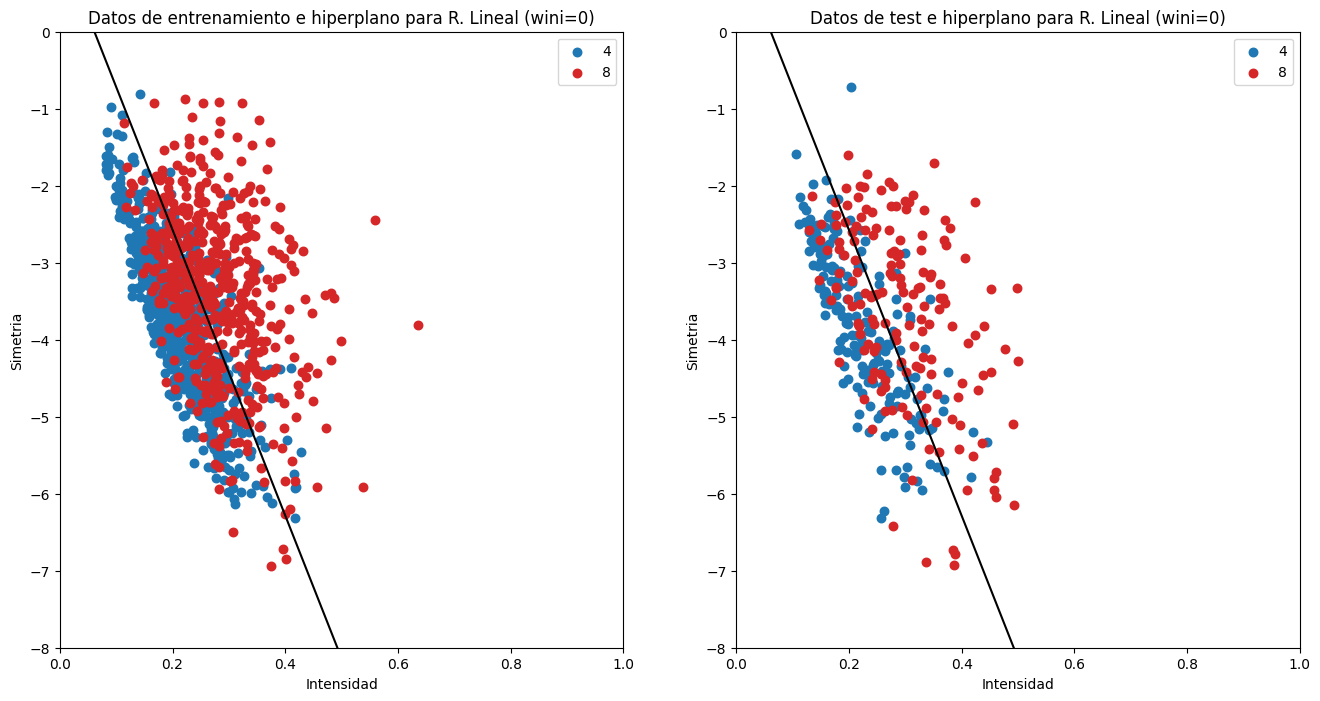

Errores en clasificacion para training:  22.780569514237854 %
Ein =  0.6428532963367777
Errores en clasificacion para test:  25.136612021857925 %
Eout =  0.7087148141159981


In [37]:
#Mostramos como ajusta cada algoritmo
#Regresión lineal
w = pseudoinverse(x, y)

#Dibujamos el conjunto de datos para poder visualizarlo
# Creo unas figura 
fig = plt.figure(figsize=(16,8))

# Separamos los datos según su clase
x_y = np.hstack((x, y.reshape(-1, 1)))

cuatro = x_y[x_y[:, -1] == -1]
ocho = x_y[x_y[:, -1] == 1]

# Visualizamos los datos con un Scatter plot
cuatro_inten = cuatro[:, 1]
cuatro_sime = cuatro[:, 2]
ocho_inten = ocho[:, 1]
ocho_sime = ocho[:, 2]

ax = fig.add_subplot(1, 2, 1)

# Dibujamos los datos
ax.scatter(cuatro_inten, cuatro_sime, color='tab:blue', marker = '.', s = 150)
ax.scatter(ocho_inten, ocho_sime, color='tab:red', marker = '.', s = 150)

# Dibujamos el hiperplano
sgdX = np.linspace(0, 1, y.size)
sgdY = (-w[0] - w[1]*sgdX) / w[2]

ax.plot(sgdX, sgdY, color=(.0, .0, .0))

# Acotamos las coordenadas de la gráfica
ax.set(xlim=(0.0, 1.0), ylim=(-8, 0))

# Añadimos los títulos
ax.set_xlabel('Intensidad')
ax.set_ylabel('Simetria')
ax.set_title('Datos de entrenamiento e hiperplano para R. Lineal (wini=0)')

# Añadimos la leyenda
ax.legend(('4', '8'), loc='upper right')


'''
        DATOS DE TEST
'''
# Separamos los datos según su clase
x_y = np.hstack((x_test, y_test.reshape(-1, 1)))

cuatro = x_y[x_y[:, -1] == -1]
ocho = x_y[x_y[:, -1] == 1]

# Visualizamos los datos con un Scatter plot
cuatro_inten = cuatro[:, 1]
cuatro_sime = cuatro[:, 2]
ocho_inten = ocho[:, 1]
ocho_sime = ocho[:, 2]

ax = fig.add_subplot(1, 2, 2)

# Dibujamos los datos
ax.scatter(cuatro_inten, cuatro_sime, color='tab:blue', marker = '.', s = 150)
ax.scatter(ocho_inten, ocho_sime, color='tab:red', marker = '.', s = 150)

# Dibujamos el hiperplano
sgdX = np.linspace(0, 1, y_test.size)
sgdY = (-w[0] - w[1]*sgdX) / w[2]

ax.plot(sgdX, sgdY, color=(.0, .0, .0))

# Acotamos las coordenadas de la gráfica
ax.set(xlim=(0.0, 1.0), ylim=(-8, 0))

# Añadimos los títulos
ax.set_xlabel('Intensidad')
ax.set_ylabel('Simetria')
ax.set_title('Datos de test e hiperplano para R. Lineal (wini=0)')

# Añadimos la leyenda
ax.legend(('4', '8'), loc='upper right')

plt.show()

print("Errores en clasificacion para training: ", clasifError(x,y,w), "%")
print("Ein = ", MSE(x,y,w))
print("Errores en clasificacion para test: ", clasifError(x_test,y_test,w), "%")
print("Eout = ", MSE(x_test,y_test,w))

Como ya veniamos comentando los valores para el error iban a ser elevados, aún así un 22.78% de error en clasificación para la muestra no está mal, aparte vemos que nuestra función no está sobreajustada, ya que el error para datos fuera de la muestra es similar (25.14%).

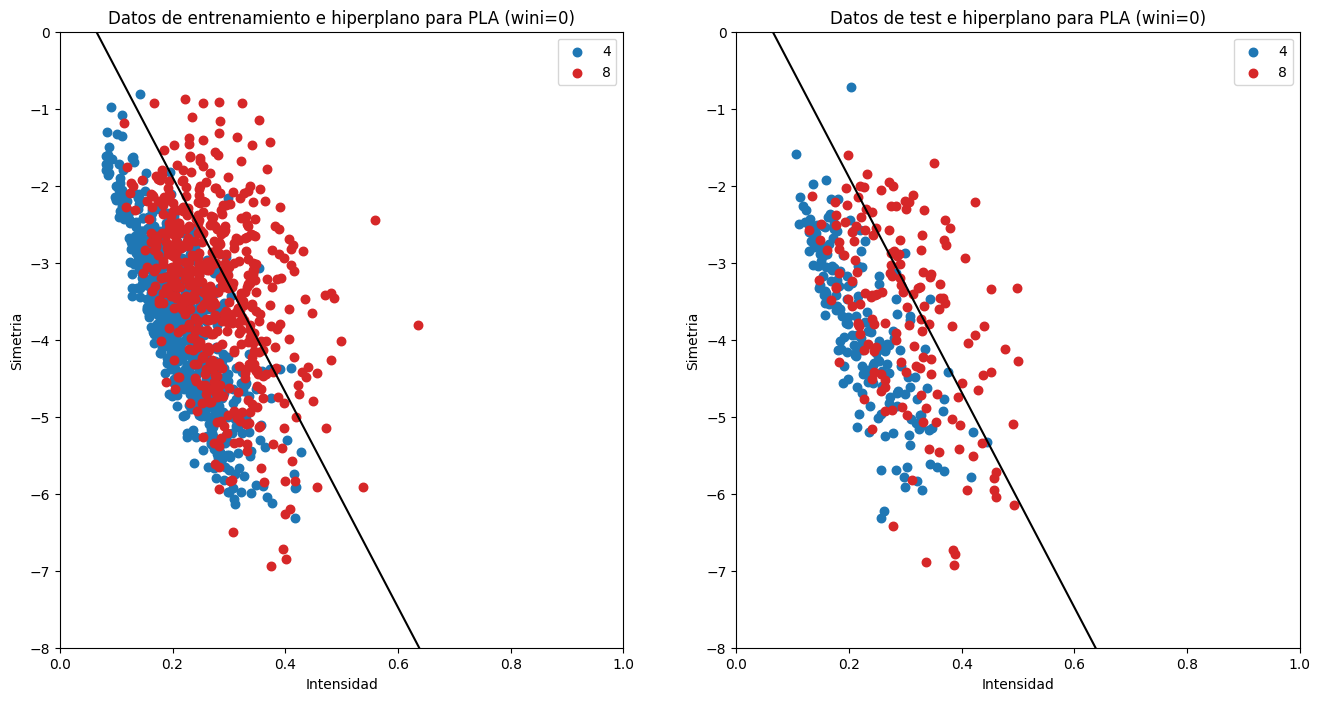

Errores en clasificacion para training:  30.90452261306533 %
Ein =  3.8529659595935044
Errores en clasificacion para test:  30.05464480874317 %
Eout =  4.092946727353459
Iteraciones hasta converger:  150444


In [38]:
#PLA
w_PLA, it = ajusta_PLA(x, y, 150000, np.array([0,0,0]))

#Dibujamos el conjunto de datos para poder visualizarlo
# Creo unas figura 
fig = plt.figure(figsize=(16,8))

# Separamos los datos según su clase
x_y = np.hstack((x, y.reshape(-1, 1)))

cuatro = x_y[x_y[:, -1] == -1]
ocho = x_y[x_y[:, -1] == 1]

# Visualizamos los datos con un Scatter plot
cuatro_inten = cuatro[:, 1]
cuatro_sime = cuatro[:, 2]
ocho_inten = ocho[:, 1]
ocho_sime = ocho[:, 2]

ax = fig.add_subplot(1, 2, 1)

# Dibujamos los datos
ax.scatter(cuatro_inten, cuatro_sime, color='tab:blue', marker = '.', s = 150)
ax.scatter(ocho_inten, ocho_sime, color='tab:red', marker = '.', s = 150)

# Dibujamos el hiperplano
sgdX = np.linspace(0, 1, y.size)
sgdY = (-w_PLA[0] - w_PLA[1]*sgdX) / w_PLA[2]

ax.plot(sgdX, sgdY, color=(.0, .0, .0))

# Acotamos las coordenadas de la gráfica
ax.set(xlim=(0.0, 1.0), ylim=(-8, 0))

# Añadimos los títulos
ax.set_xlabel('Intensidad')
ax.set_ylabel('Simetria')
ax.set_title('Datos de entrenamiento e hiperplano para PLA (wini=0)')

# Añadimos la leyenda
ax.legend(('4', '8'), loc='upper right')


'''
        DATOS DE TEST
'''
# Separamos los datos según su clase
x_y = np.hstack((x_test, y_test.reshape(-1, 1)))

cuatro = x_y[x_y[:, -1] == -1]
ocho = x_y[x_y[:, -1] == 1]

# Visualizamos los datos con un Scatter plot
cuatro_inten = cuatro[:, 1]
cuatro_sime = cuatro[:, 2]
ocho_inten = ocho[:, 1]
ocho_sime = ocho[:, 2]

ax = fig.add_subplot(1, 2, 2)

# Dibujamos los datos
ax.scatter(cuatro_inten, cuatro_sime, color='tab:blue', marker = '.', s = 150)
ax.scatter(ocho_inten, ocho_sime, color='tab:red', marker = '.', s = 150)

# Dibujamos el hiperplano
sgdX = np.linspace(0, 1, y_test.size)
sgdY = (-w_PLA[0] - w_PLA[1]*sgdX) / w_PLA[2]

ax.plot(sgdX, sgdY, color=(.0, .0, .0))

# Acotamos las coordenadas de la gráfica
ax.set(xlim=(0.0, 1.0), ylim=(-8, 0))

# Añadimos los títulos
ax.set_xlabel('Intensidad')
ax.set_ylabel('Simetria')
ax.set_title('Datos de test e hiperplano para PLA (wini=0)')

# Añadimos la leyenda
ax.legend(('4', '8'), loc='upper right')

plt.show()

print("Errores en clasificacion para training: ", clasifError(x,y,w_PLA), "%")
print("Ein = ", Err_PLA(x,y,w_PLA))
print("Errores en clasificacion para test: ", clasifError(x_test,y_test,w_PLA), "%")
print("Eout = ", Err_PLA(x_test,y_test,w_PLA))
print("Iteraciones hasta converger: ", it)

El ajuste con PLA es algo peor que con regresión lineal, vemos que gasta todas las iteraciones disponibles, por lo que constantemente está actualizando los pesos, como ya hemos dicho antes es muy probable que PLA haya encontrado algún ajuste mejor pero lo haya perdido al actualizar pesos, veremos con PLA-Pocket si mejora el ajuste.

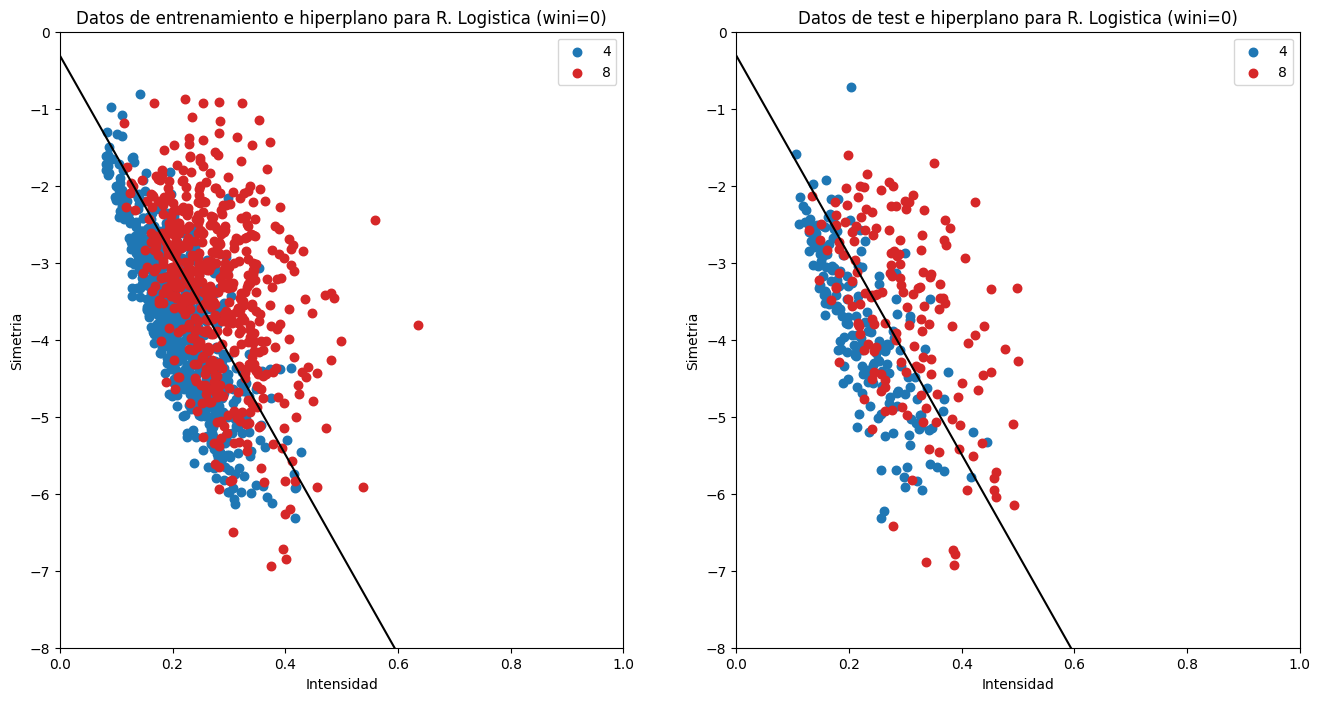

Errores en clasificacion para training:  22.529313232830823 %
Ein =  0.49394029396544065
Errores en clasificacion para test:  26.229508196721312 %
Eout =  0.5421329365005753
Epocas hasta converger:  1304


In [40]:
np.random.seed(0)

#RL
w_RL, ep = sgdRL(x, y, 1, 32, 75000)

#Dibujamos el conjunto de datos para poder visualizarlo
# Creo unas figura 
fig = plt.figure(figsize=(16,8))

# Separamos los datos según su clase
x_y = np.hstack((x, y.reshape(-1, 1)))

cuatro = x_y[x_y[:, -1] == -1]
ocho = x_y[x_y[:, -1] == 1]

# Visualizamos los datos con un Scatter plot
cuatro_inten = cuatro[:, 1]
cuatro_sime = cuatro[:, 2]
ocho_inten = ocho[:, 1]
ocho_sime = ocho[:, 2]

ax = fig.add_subplot(1, 2, 1)

# Dibujamos los datos
ax.scatter(cuatro_inten, cuatro_sime, color='tab:blue', marker = '.', s = 150)
ax.scatter(ocho_inten, ocho_sime, color='tab:red', marker = '.', s = 150)

# Dibujamos el hiperplano
sgdX = np.linspace(0, 1, y.size)
sgdY = (-w_RL[0] - w_RL[1]*sgdX) / w_RL[2]

ax.plot(sgdX, sgdY, color=(.0, .0, .0))

# Acotamos las coordenadas de la gráfica
ax.set(xlim=(0.0, 1.0), ylim=(-8, 0))

# Añadimos los títulos
ax.set_xlabel('Intensidad')
ax.set_ylabel('Simetria')
ax.set_title('Datos de entrenamiento e hiperplano para R. Logistica (wini=0)')

# Añadimos la leyenda
ax.legend(('4', '8'), loc='upper right')


'''
        DATOS DE TEST
'''
# Separamos los datos según su clase
x_y = np.hstack((x_test, y_test.reshape(-1, 1)))

cuatro = x_y[x_y[:, -1] == -1]
ocho = x_y[x_y[:, -1] == 1]

# Visualizamos los datos con un Scatter plot
cuatro_inten = cuatro[:, 1]
cuatro_sime = cuatro[:, 2]
ocho_inten = ocho[:, 1]
ocho_sime = ocho[:, 2]

ax = fig.add_subplot(1, 2, 2)

# Dibujamos los datos
ax.scatter(cuatro_inten, cuatro_sime, color='tab:blue', marker = '.', s = 150)
ax.scatter(ocho_inten, ocho_sime, color='tab:red', marker = '.', s = 150)

# Dibujamos el hiperplano
sgdX = np.linspace(0, 1, y_test.size)
sgdY = (-w_RL[0] - w_RL[1]*sgdX) / w_RL[2]

ax.plot(sgdX, sgdY, color=(.0, .0, .0))

# Acotamos las coordenadas de la gráfica
ax.set(xlim=(0.0, 1.0), ylim=(-8, 0))

# Añadimos los títulos
ax.set_xlabel('Intensidad')
ax.set_ylabel('Simetria')
ax.set_title('Datos de test e hiperplano para R. Logistica (wini=0)')

# Añadimos la leyenda
ax.legend(('4', '8'), loc='upper right')

plt.show()

print("Errores en clasificacion para training: ", clasifError(x,y,w_RL), "%")
print("Ein = ", Err(x,y,w_RL))
print("Errores en clasificacion para test: ", clasifError(x_test,y_test,w_RL), "%")
print("Eout = ", Err(x_test,y_test,w_RL))
print("Epocas hasta converger: ", ep)

Con RL ya sabemos que debemos ir probando distintos valores de learning rate y de minibatch, empezamos con 1 y 32 respectivamente con los que obtenemos un error en clasificación muestral del 22.45% y un $E_{in} = 0.49$, como son unos valores de error bastante aceptables para RL por como están superpuestos los datos unos sobre otros me quedo con ellos.

En cuanto a conjuntos de datos fuera de la muestra tenemos un error en clasificación del 26.23% y un $E_{out} = 0.54$, por lo que confirmamos que nuestra función no está sobreajustada.

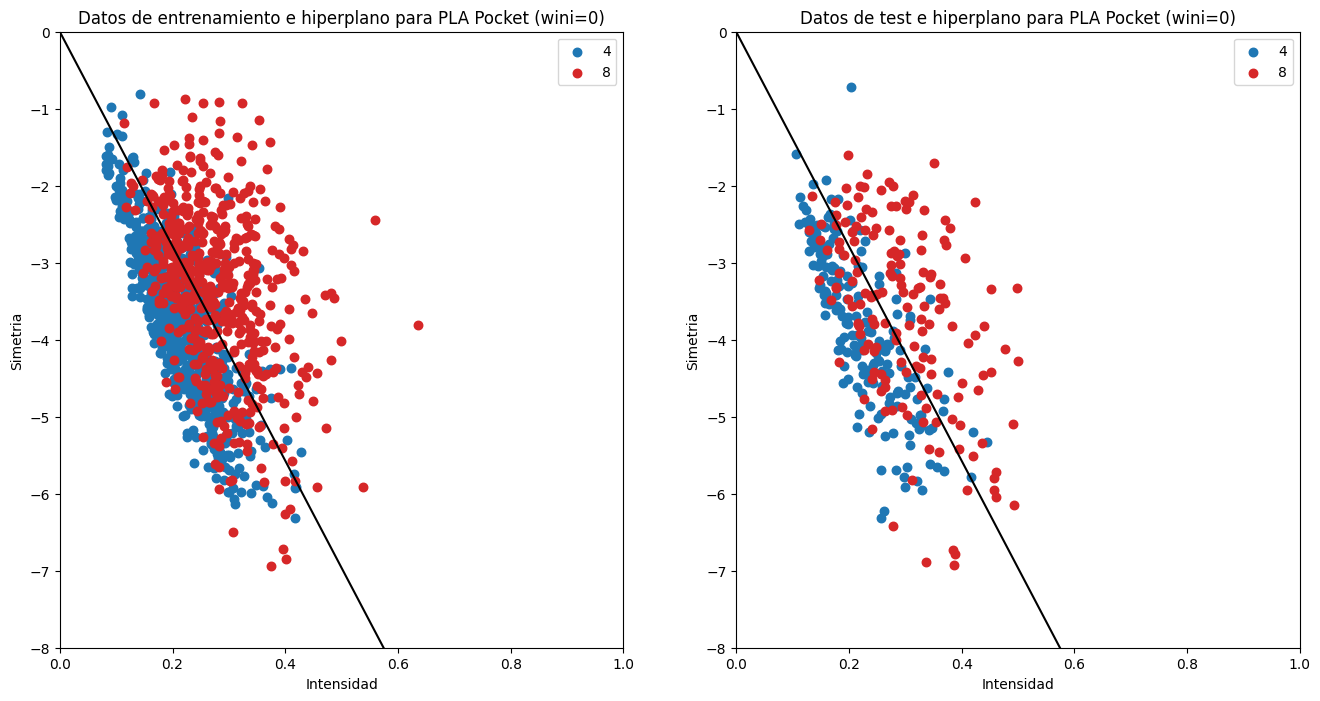

Errores en clasificacion para training:  22.36180904522613 %
Ein =  0.1670279056923322
Errores en clasificacion para test:  24.863387978142075 %
Eout =  0.21088371580719648
Iteraciones hasta converger:  50148


In [41]:
#PLA_pocket
w_pocket, it = ajusta_PLA_Pocket(x, y, 50000, np.array([0,0,0]))

#Dibujamos el conjunto de datos para poder visualizarlo
# Creo unas figura 
fig = plt.figure(figsize=(16,8))

# Separamos los datos según su clase
x_y = np.hstack((x, y.reshape(-1, 1)))

cuatro = x_y[x_y[:, -1] == -1]
ocho = x_y[x_y[:, -1] == 1]

# Visualizamos los datos con un Scatter plot
cuatro_inten = cuatro[:, 1]
cuatro_sime = cuatro[:, 2]
ocho_inten = ocho[:, 1]
ocho_sime = ocho[:, 2]

ax = fig.add_subplot(1, 2, 1)

# Dibujamos los datos
ax.scatter(cuatro_inten, cuatro_sime, color='tab:blue', marker = '.', s = 150)
ax.scatter(ocho_inten, ocho_sime, color='tab:red', marker = '.', s = 150)

# Dibujamos el hiperplano
sgdX = np.linspace(0, 1, y.size)
sgdY = (-w_pocket[0] - w_pocket[1]*sgdX) / w_pocket[2]

ax.plot(sgdX, sgdY, color=(.0, .0, .0))

# Acotamos las coordenadas de la gráfica
ax.set(xlim=(0.0, 1.0), ylim=(-8, 0))

# Añadimos los títulos
ax.set_xlabel('Intensidad')
ax.set_ylabel('Simetria')
ax.set_title('Datos de entrenamiento e hiperplano para PLA Pocket (wini=0)')

# Añadimos la leyenda
ax.legend(('4', '8'), loc='upper right')


'''
        DATOS DE TEST
'''
# Separamos los datos según su clase
x_y = np.hstack((x_test, y_test.reshape(-1, 1)))

cuatro = x_y[x_y[:, -1] == -1]
ocho = x_y[x_y[:, -1] == 1]

# Visualizamos los datos con un Scatter plot
cuatro_inten = cuatro[:, 1]
cuatro_sime = cuatro[:, 2]
ocho_inten = ocho[:, 1]
ocho_sime = ocho[:, 2]

ax = fig.add_subplot(1, 2, 2)

# Dibujamos los datos
ax.scatter(cuatro_inten, cuatro_sime, color='tab:blue', marker = '.', s = 150)
ax.scatter(ocho_inten, ocho_sime, color='tab:red', marker = '.', s = 150)

# Dibujamos el hiperplano
sgdX = np.linspace(0, 1, y_test.size)
sgdY = (-w_pocket[0] - w_pocket[1]*sgdX) / w_pocket[2]

ax.plot(sgdX, sgdY, color=(.0, .0, .0))

# Acotamos las coordenadas de la gráfica
ax.set(xlim=(0.0, 1.0), ylim=(-8, 0))

# Añadimos los títulos
ax.set_xlabel('Intensidad')
ax.set_ylabel('Simetria')
ax.set_title('Datos de test e hiperplano para PLA Pocket (wini=0)')

# Añadimos la leyenda
ax.legend(('4', '8'), loc='upper right')

plt.show()

print("Errores en clasificacion para training: ", clasifError(x,y,w_pocket), "%")
print("Ein = ", Err_PLA(x,y,w_pocket))
print("Errores en clasificacion para test: ", clasifError(x_test,y_test,w_pocket), "%")
print("Eout = ", Err_PLA(x_test,y_test,w_pocket))
print("Iteraciones hasta converger: ", it)

Debido a que a diferencia de PLA su versión Pocket tiene que calcular el $E_{in}$, el tiempo de computo aumenta considerablemente, por lo que reduzco en un tercio el número máximo de iteraciones disponibles.

En cuanto a los resultados, como comentabamos en PLA, estos son mejores y PLA actualiza a peor los pesos en algunas iteraciones, tenemos un error en clasificación muestral del 22.36%, similar a RL, un $E_{in} = 0.17$ y para datos fuera de la muestra un error en clasificación del 24.86%, de nuevo no sobreajustamos la función y un $E_{out} = 0.21$

Con esta ejecución hemos podido ver los pros y contras de usar PLA-Pocket frente a PLA, mejores resultados frente a mayor tiempo de cómputo.

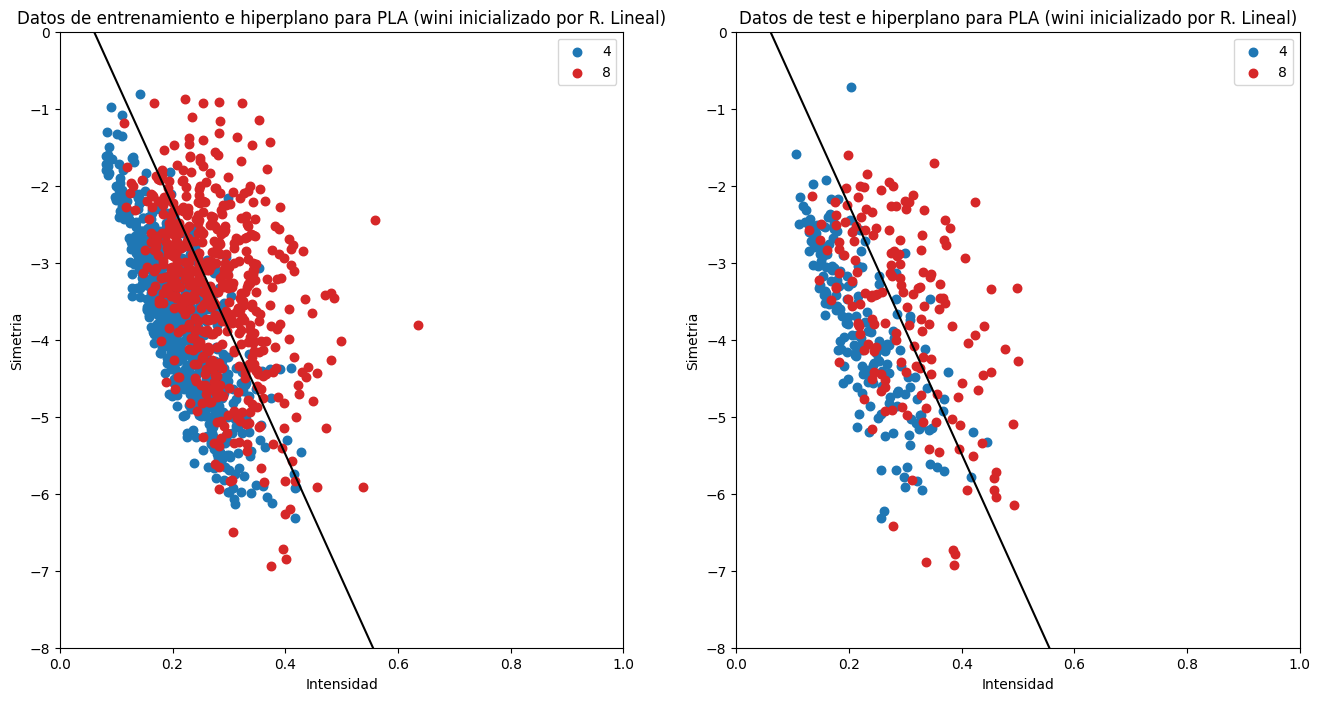

Errores en clasificacion para training:  25.20938023450586 %
Ein =  2.17107917996781
Errores en clasificacion para test:  25.136612021857925 %
Eout =  2.4584209620245283
Iteraciones hasta converger:  150444


array([-0.50676351,  8.25119739,  0.44464113])

In [50]:
#PLA usando como pesos iniciales los ajustados por R. Lineal
w_PLA, it = ajusta_PLA(x, y, 150000, w)

#Dibujamos el conjunto de datos para poder visualizarlo
# Creo unas figura 
fig = plt.figure(figsize=(16,8))

# Separamos los datos según su clase
x_y = np.hstack((x, y.reshape(-1, 1)))

cuatro = x_y[x_y[:, -1] == -1]
ocho = x_y[x_y[:, -1] == 1]

# Visualizamos los datos con un Scatter plot
cuatro_inten = cuatro[:, 1]
cuatro_sime = cuatro[:, 2]
ocho_inten = ocho[:, 1]
ocho_sime = ocho[:, 2]

ax = fig.add_subplot(1, 2, 1)

# Dibujamos los datos
ax.scatter(cuatro_inten, cuatro_sime, color='tab:blue', marker = '.', s = 150)
ax.scatter(ocho_inten, ocho_sime, color='tab:red', marker = '.', s = 150)

# Dibujamos el hiperplano
sgdX = np.linspace(0, 1, y.size)
sgdY = (-w_PLA[0] - w_PLA[1]*sgdX) / w_PLA[2]

ax.plot(sgdX, sgdY, color=(.0, .0, .0))

# Acotamos las coordenadas de la gráfica
ax.set(xlim=(0.0, 1.0), ylim=(-8, 0))

# Añadimos los títulos
ax.set_xlabel('Intensidad')
ax.set_ylabel('Simetria')
ax.set_title('Datos de entrenamiento e hiperplano para PLA (wini inicializado por R. Lineal)')

# Añadimos la leyenda
ax.legend(('4', '8'), loc='upper right')


'''
        DATOS DE TEST
'''
# Separamos los datos según su clase
x_y = np.hstack((x_test, y_test.reshape(-1, 1)))

cuatro = x_y[x_y[:, -1] == -1]
ocho = x_y[x_y[:, -1] == 1]

# Visualizamos los datos con un Scatter plot
cuatro_inten = cuatro[:, 1]
cuatro_sime = cuatro[:, 2]
ocho_inten = ocho[:, 1]
ocho_sime = ocho[:, 2]

ax = fig.add_subplot(1, 2, 2)

# Dibujamos los datos
ax.scatter(cuatro_inten, cuatro_sime, color='tab:blue', marker = '.', s = 150)
ax.scatter(ocho_inten, ocho_sime, color='tab:red', marker = '.', s = 150)

# Dibujamos el hiperplano
sgdX = np.linspace(0, 1, y_test.size)
sgdY = (-w_PLA[0] - w_PLA[1]*sgdX) / w_PLA[2]

ax.plot(sgdX, sgdY, color=(.0, .0, .0))

# Acotamos las coordenadas de la gráfica
ax.set(xlim=(0.0, 1.0), ylim=(-8, 0))

# Añadimos los títulos
ax.set_xlabel('Intensidad')
ax.set_ylabel('Simetria')
ax.set_title('Datos de test e hiperplano para PLA (wini inicializado por R. Lineal)')

# Añadimos la leyenda
ax.legend(('4', '8'), loc='upper right')

plt.show()

print("Errores en clasificacion para training: ", clasifError(x,y,w_PLA), "%")
print("Ein = ", Err_PLA(x,y,w_PLA))
print("Errores en clasificacion para test: ", clasifError(x_test,y_test,w_PLA), "%")
print("Eout = ", Err_PLA(x_test,y_test,w_PLA))
print("Iteraciones hasta converger: ", it)

Inicializando ahora los pesos con el resultado de aplicarles R. Lineal obtenemos mejores resultados para todos los errores, por ejemplo el error en clasificación muestral antes se situaba en un 30.9%, ahora en un 25.21% y así con todos. Esto se debe a que R. Lineal ya se encarga de converger los pesos hasta un mínimo local, por lo que al usar luego PLA o cualquier otro algoritmo de la práctica somos capaces de que los pesos convergan aún más hacia el óptimo. 

El problema que observamos con PLA en concreto es que recordemos que el ajuste de los pesos puede empeorar, y en efecto empeora respecto a los resultados que nos daba aplicar R. Lineal, este tenía un error en clasificación muestral en torno al 22% y ahora tenemos un 25.21%, veremos para RL y PLA-Pocket como cambia el ajuste. 

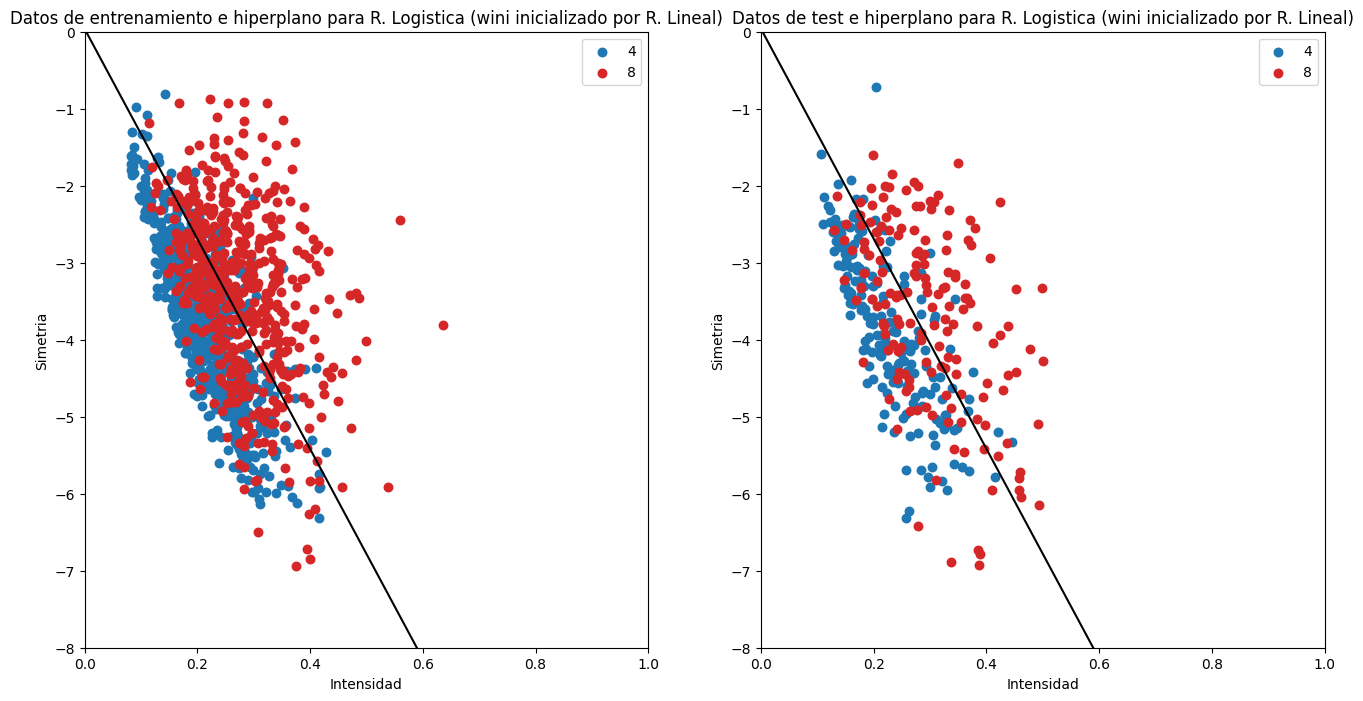

Errores en clasificacion para training:  22.613065326633166 %
Ein =  0.4939372419494266
Errores en clasificacion para test:  25.40983606557377 %
Eout =  0.5471457849583855
Epocas hasta converger:  1299
Valor de wini:  [-0.50676351  8.25119739  0.44464113]


In [45]:
#Redefinimos el algoritmo de RL para poder inicializar los pesos al valor que queramos
def sgdRL(x, y, lr, tam_minibatch, max_epocas, wini):
  #Inicializo pesos
  w = np.copy(wini)
  w_ante = np.copy(wini)
  ep = 0

  while(ep < max_epocas):
    #Permutamos y seleccionamos un minibatch de la muestra
    random_perm = np.random.permutation(x.shape[0])
    random_perm = random_perm[0:tam_minibatch]

    #Calculamos el gradiente
    aux = 0
    for i in random_perm:
      aux = aux + SGD_RL(x[i],y[i],w) 

    w = w - lr * (aux/tam_minibatch) #Actualizamos pesos
    ep = ep+1

    #Comprobamos ||w(t-1) - wt|| < 0.01
    delta = np.linalg.norm(w_ante-w)
    if(delta < 0.01):
      return w, ep
    
    w_ante = np.copy(w)
  
  return w, ep

#RL usando como pesos iniciales los ajustados por R. Lineal
np.random.seed(0)

w_RL, ep = sgdRL(x, y, 1, 32, 75000, w)

#Dibujamos el conjunto de datos para poder visualizarlo
# Creo unas figura 
fig = plt.figure(figsize=(16,8))

# Separamos los datos según su clase
x_y = np.hstack((x, y.reshape(-1, 1)))

cuatro = x_y[x_y[:, -1] == -1]
ocho = x_y[x_y[:, -1] == 1]

# Visualizamos los datos con un Scatter plot
cuatro_inten = cuatro[:, 1]
cuatro_sime = cuatro[:, 2]
ocho_inten = ocho[:, 1]
ocho_sime = ocho[:, 2]

ax = fig.add_subplot(1, 2, 1)

# Dibujamos los datos
ax.scatter(cuatro_inten, cuatro_sime, color='tab:blue', marker = '.', s = 150)
ax.scatter(ocho_inten, ocho_sime, color='tab:red', marker = '.', s = 150)

# Dibujamos el hiperplano
sgdX = np.linspace(0, 1, y.size)
sgdY = (-w_RL[0] - w_RL[1]*sgdX) / w_RL[2]

ax.plot(sgdX, sgdY, color=(.0, .0, .0))

# Acotamos las coordenadas de la gráfica
ax.set(xlim=(0.0, 1.0), ylim=(-8, 0))

# Añadimos los títulos
ax.set_xlabel('Intensidad')
ax.set_ylabel('Simetria')
ax.set_title('Datos de entrenamiento e hiperplano para R. Logistica (wini inicializado por R. Lineal)')

# Añadimos la leyenda
ax.legend(('4', '8'), loc='upper right')


'''
        DATOS DE TEST
'''
# Separamos los datos según su clase
x_y = np.hstack((x_test, y_test.reshape(-1, 1)))

cuatro = x_y[x_y[:, -1] == -1]
ocho = x_y[x_y[:, -1] == 1]

# Visualizamos los datos con un Scatter plot
cuatro_inten = cuatro[:, 1]
cuatro_sime = cuatro[:, 2]
ocho_inten = ocho[:, 1]
ocho_sime = ocho[:, 2]

ax = fig.add_subplot(1, 2, 2)

# Dibujamos los datos
ax.scatter(cuatro_inten, cuatro_sime, color='tab:blue', marker = '.', s = 150)
ax.scatter(ocho_inten, ocho_sime, color='tab:red', marker = '.', s = 150)

# Dibujamos el hiperplano
sgdX = np.linspace(0, 1, y_test.size)
sgdY = (-w_RL[0] - w_RL[1]*sgdX) / w_RL[2]

ax.plot(sgdX, sgdY, color=(.0, .0, .0))

# Acotamos las coordenadas de la gráfica
ax.set(xlim=(0.0, 1.0), ylim=(-8, 0))

# Añadimos los títulos
ax.set_xlabel('Intensidad')
ax.set_ylabel('Simetria')
ax.set_title('Datos de test e hiperplano para R. Logistica (wini inicializado por R. Lineal)')

# Añadimos la leyenda
ax.legend(('4', '8'), loc='upper right')

plt.show()

print("Errores en clasificacion para training: ", clasifError(x,y,w_RL), "%")
print("Ein = ", Err(x,y,w_RL))
print("Errores en clasificacion para test: ", clasifError(x_test,y_test,w_RL), "%")
print("Eout = ", Err(x_test,y_test,w_RL))
print("Epocas hasta converger: ", ep)
print("Valor de wini: ", w)

Usando la misma configuración de antes obtenemos un error en clasificación muestral de 22.61%, esto es menos que el 22.78% de R. Lineal, pero más que 22.53% de RL inicializando los pesos a 0, esto se debe a que en RL el valor al que se inicialicen los pesos influyen en el tiempo que el algoritmo tardará en converger, al ser los valores de wini cercanos a 0 no hay mucho cambio con respecto a inicializar los pesos a 0, esto lo podemos observar en que se hacen casi las mismas épocas en ambos casos, 1304 frente a 1299 aquí.



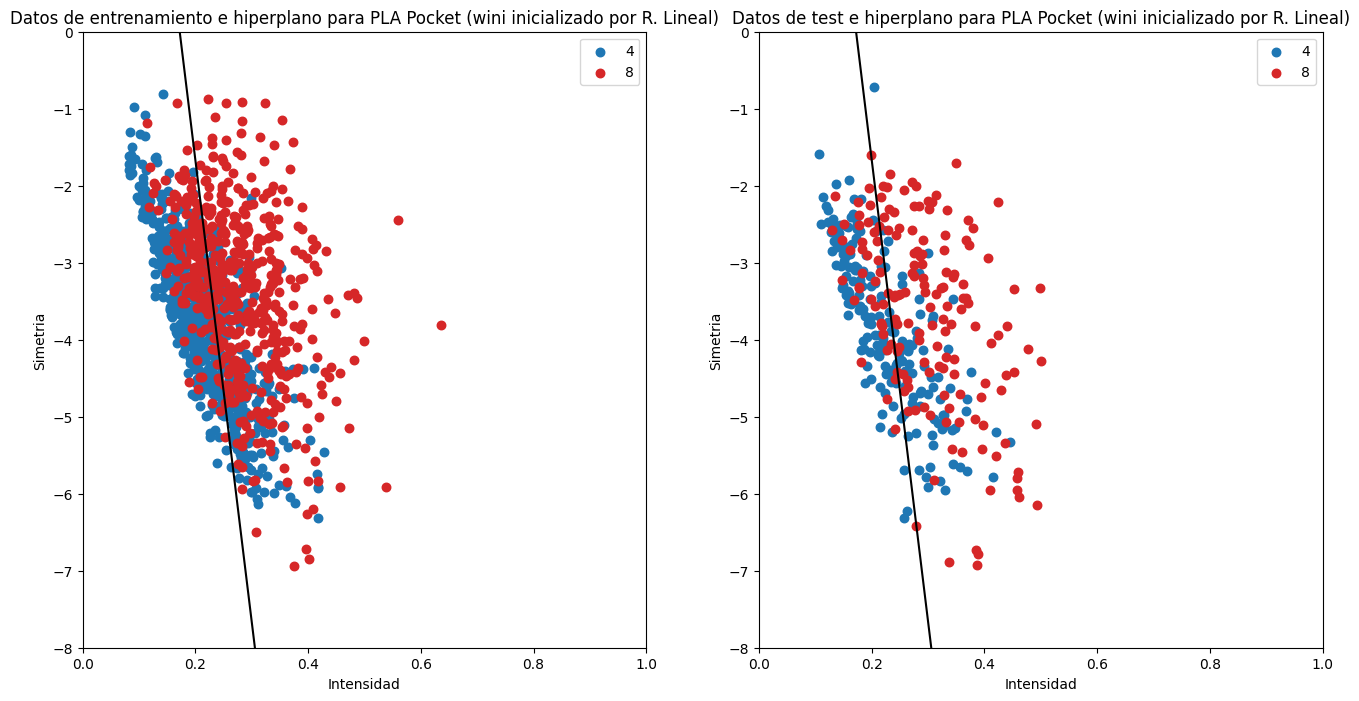

Errores en clasificacion para training:  28.726968174204355 %
Ein =  0.08908696303162242
Errores en clasificacion para test:  33.060109289617486 %
Eout =  0.11874127889421897
Iteraciones hasta converger:  50148


In [52]:
#PLA_pocket usando como pesos iniciales los ajustados por R. Lineal
w_pocket, it = ajusta_PLA_Pocket(x, y, 50000, w)

#Dibujamos el conjunto de datos para poder visualizarlo
# Creo unas figura 
fig = plt.figure(figsize=(16,8))

# Separamos los datos según su clase
x_y = np.hstack((x, y.reshape(-1, 1)))

cuatro = x_y[x_y[:, -1] == -1]
ocho = x_y[x_y[:, -1] == 1]

# Visualizamos los datos con un Scatter plot
cuatro_inten = cuatro[:, 1]
cuatro_sime = cuatro[:, 2]
ocho_inten = ocho[:, 1]
ocho_sime = ocho[:, 2]

ax = fig.add_subplot(1, 2, 1)

# Dibujamos los datos
ax.scatter(cuatro_inten, cuatro_sime, color='tab:blue', marker = '.', s = 150)
ax.scatter(ocho_inten, ocho_sime, color='tab:red', marker = '.', s = 150)

# Dibujamos el hiperplano
sgdX = np.linspace(0, 1, y.size)
sgdY = (-w_pocket[0] - w_pocket[1]*sgdX) / w_pocket[2]

ax.plot(sgdX, sgdY, color=(.0, .0, .0))

# Acotamos las coordenadas de la gráfica
ax.set(xlim=(0.0, 1.0), ylim=(-8, 0))

# Añadimos los títulos
ax.set_xlabel('Intensidad')
ax.set_ylabel('Simetria')
ax.set_title('Datos de entrenamiento e hiperplano para PLA Pocket (wini inicializado por R. Lineal)')

# Añadimos la leyenda
ax.legend(('4', '8'), loc='upper right')


'''
        DATOS DE TEST
'''
# Separamos los datos según su clase
x_y = np.hstack((x_test, y_test.reshape(-1, 1)))

cuatro = x_y[x_y[:, -1] == -1]
ocho = x_y[x_y[:, -1] == 1]

# Visualizamos los datos con un Scatter plot
cuatro_inten = cuatro[:, 1]
cuatro_sime = cuatro[:, 2]
ocho_inten = ocho[:, 1]
ocho_sime = ocho[:, 2]

ax = fig.add_subplot(1, 2, 2)

# Dibujamos los datos
ax.scatter(cuatro_inten, cuatro_sime, color='tab:blue', marker = '.', s = 150)
ax.scatter(ocho_inten, ocho_sime, color='tab:red', marker = '.', s = 150)

# Dibujamos el hiperplano
sgdX = np.linspace(0, 1, y_test.size)
sgdY = (-w_pocket[0] - w_pocket[1]*sgdX) / w_pocket[2]

ax.plot(sgdX, sgdY, color=(.0, .0, .0))

# Acotamos las coordenadas de la gráfica
ax.set(xlim=(0.0, 1.0), ylim=(-8, 0))

# Añadimos los títulos
ax.set_xlabel('Intensidad')
ax.set_ylabel('Simetria')
ax.set_title('Datos de test e hiperplano para PLA Pocket (wini inicializado por R. Lineal)')

# Añadimos la leyenda
ax.legend(('4', '8'), loc='upper right')

plt.show()

print("Errores en clasificacion para training: ", clasifError(x,y,w_pocket), "%")
print("Ein = ", Err_PLA(x,y,w_pocket))
print("Errores en clasificacion para test: ", clasifError(x_test,y_test,w_pocket), "%")
print("Eout = ", Err_PLA(x_test,y_test,w_pocket))
print("Iteraciones hasta converger: ", it)

En cuanto a PLA-Pocket pasa lo mismo que con PLA, la inicialización de los pesos influye en cuanto tardará en converger el algoritmo dependiendo de donde esté el peso final, con 50000 iteraciones obtenemos un resultado peor que en PLA y que en PLA-Pocket inicializando los pesos a 0, esto quiere decir que nos hemos alejado del punto óptimo, lo cual a su vez nos indica que los pesos ajustados que nos devuelve R. Lineal corresponden a un mínimo local, pero que no tiene porque estar encaminado al óptimo y de hecho no lo está.

In [55]:
#Calculo de cota Eout verdadera
#En base al Ein
def cota_Ein(Ein, tam, tolerancia, dVC):
  return Ein + np.sqrt((8/tam) * np.log((4 * ((2*tam)**dVC + 1))/tolerancia))

#En base al Etest
def cota_Etest(Etest, tam, tolerancia, h):
  return Etest + np.sqrt((1/2*tam) * np.log(2*h/tolerancia))

#Errores de los algoritmos en base a los pesos calculados en sus ultimas ejecuciones
E_in_pseu = MSE(x,y,w)
E_in_PLA = Err_PLA(x,y,w_PLA)
E_in_RL = Err(x,y,w_RL)
E_in_Pocket = Err_PLA(x,y,w_pocket)
E_test_pseu = MSE(x_test,y_test,w)
E_test_PLA = Err_PLA(x_test,y_test,w_PLA)
E_test_RL = Err(x_test,y_test,w_RL)
E_test_Pocket = Err_PLA(x_test,y_test,w_pocket)

tam = x.shape[0]
tam_test = x_test.shape[0]

print("Cota Eout verdadera en R. Lineal basada en Ein:", cota_Ein(E_in_pseu, tam, 0.05, 3))
print("Cota Eout verdadera en R. Lineal basada en Etest:", cota_Etest(E_test_pseu, tam_test, 0.05, 1))
print("Cota Eout verdadera en PLA basada en Ein:", cota_Ein(E_in_PLA, tam, 0.05, 3))
print("Cota Eout verdadera en PLA basada en Etest:", cota_Etest(E_test_PLA, tam_test, 0.05, 1))
print("Cota Eout verdadera en RL basada en Ein:", cota_Ein(E_in_RL, tam, 0.05, 3))
print("Cota Eout verdadera en RL basada en Etest:", cota_Etest(E_test_RL, tam_test, 0.05, 1))
print("Cota Eout verdadera en PLA-Pocket basada en Ein:", cota_Ein(E_in_Pocket, tam, 0.05, 3))
print("Cota Eout verdadera en PLA-Pocket basada en Etest:", cota_Etest(E_test_Pocket, tam_test, 0.05, 1))

Cota Eout verdadera en R. Lineal basada en Ein: 1.0737898018074814
Cota Eout verdadera en R. Lineal basada en Etest: 26.690726670453262
Cota Eout verdadera en PLA basada en Ein: 2.6020156854385137
Cota Eout verdadera en PLA basada en Etest: 28.440432818361796
Cota Eout verdadera en RL basada en Ein: 0.9248737474201303
Cota Eout verdadera en RL basada en Etest: 26.52915764129565
Cota Eout verdadera en PLA-Pocket basada en Ein: 0.5200234685023261
Cota Eout verdadera en PLA-Pocket basada en Etest: 26.100753135231486


A la hora de calcular las cotas necesitamos la dimensión VC de los algoritmos al calcularlas en base a Ein, la dimensión VC son los grados de libertad del modelo lineal, es decir el número de pesos que este tenga, en nuestro caso 3 para todos los algoritmos.

Si calculamos las cotas en base a Etest necesitamos la cardinalidad de H, es decir, el número de hipótesis que tenemos, en todos nuestros casos solo calculamos una hipótesis(una frontera de decisión), por lo que marcamos a 1 ese parámetro en todos los casos.

Viendo las cotas obtenidas observamos que estas están más acotadas cuando se calculan en base a Ein, por lo que estas nos aportan más información sobre Eout, ya que este es como mucho tan grande como los valores devueltos, en cuanto a que algoritmo es mejor respecto a las cotas obtenidas está claro que ese es PLA-Pocket, ya que su Eout puede ser como mucho de 0.52, PLA sin embargo al no tener en cuenta si los pesos actuales son mejores que a los que va a actualizar es más aleatorio y en este caso es el que peor cota tiene.